<a href="https://colab.research.google.com/github/PatoTlax/Transport/blob/main/10_Insights_Jorge_Velazquez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importando Librerías**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import pandas as pd
import statistics
import plotly.express as px
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline

# **Importando Archivo de manera local**

In [ ]:
#Importar Archivo csv desde la computadora
from google.colab import files
files.upload()
df = pd.read_csv('Trucargospy.csv')

Saving Trucargospy.csv to Trucargospy.csv


In [ ]:
df.tail()

,IDGas,Estación de carga,IDSupervisor,Fecha,IdUtilitarios,IdVanyBus,IdPersonal,IDRabon,IdTracto,IdOp,Tipo de Combustible,Litros,Precio por litro,Total
2897,2898,ESENCIA,2,10/12/2022,NaN,NaN,6.0,NaN,NaN,92,Diesel,120,23.51,2821.20
2898,2899,ESENCIA,2,10/12/2022,NaN,17.0,NaN,NaN,NaN,91,Gasolina,37,21.35,789.95
2899,2900,ESENCIA,6,11/12/2022,NaN,NaN,16.0,NaN,NaN,3,Diesel,165,23.51,3879.15
2900,2901,ESENCIA,3,11/12/2022,NaN,NaN,25.0,NaN,NaN,22,Diesel,165,23.51,3879.15
2901,2902,ESENCIA,2,11/12/2022,NaN,NaN,8.0,NaN,NaN,37,Diesel,60,23.51,1410.60


In [ ]:
df.shape

(2902, 14)

In [ ]:
df['Total'].sum()

17544625.21

In [ ]:
df['Litros'].sum()

751438

# **Glosario**

*   **IdGas:** Id único para identificar la carga de combustible
*   **Estación de carga:** Nombre del proveedor de combustible
*   **IDSupervisor:** Registro único del supervisor que autoriza la carga de combustible
*   **Fecha:** Fecha en la que se capturo el registro
*   **IdUtilitarios:** Registro único de las unidades del segmento de 'Utilitarios'
*   **IdVanyBus:** Registro único de las unidades del segmento de 'Turismo'
*   **IdPersonal:** Registro único de las unidades del segmento de 'Transporte de personal'
*   **IdRabon:** Registro único de las unidades del segmento de 'Rabones'(unidades de carga con poco arrastre)
*   **IdTracto:** Registro único de las unidades del segmento de 'Transporte de carga'
*   **IdOp:** Registro único de los operadores encargados de conducir una unidad
*   **Tipo de Combustible:** Muestra el tipo de combustible que utiliza la unidad, puede ser 'Diesel' o 'Gasolina'
*   **Litros:** Cantidad de litros suministrados a la unidad
*   **Precio por litro:** Precio del litro de combustible en el momento del abastecimiento
*   **Total:** Importe total de la carga de combustible

# **Problema empresarial o comercial:**

La empresa en la que trabajo, es una empresa de transporte que tiene presencia a nivel nacional, la cual brinda servicio a 5 segmentos de logistíca y transporte:


*   Utilitarios
*   Vanes y Buses
*   Transporte de Personal
*   Rabones
*   Transporte de Carga


El volumen de combustible que consumen es bastante alto ya que cuentan con unidades de transporte que recorren todo el país, o realizan diferentes circuitos para diferentes empresas, principalmente del sector automotriz, y al tener diferentes proveedores de combustible necesitan saber con exactitud el consumo efectivo por unidad, por segmento, y por proveedor de hidrocarburos.

Un objetivo importante a desarrollar a futuro es identificar las malas practicas de algunos operadores de las unidades en el transporte de carga, a quienes se les sospecha la extracción de combustible de la unidad que tienen a su cargo.

**Necesitamos resolver puntualmente las siguientes preguntas:**
* ¿Qué unidades estan consumiendo más combustible?
* ¿Qué estaciones de hidrocarburos cargan más combustible?
* ¿Qué segmentos del transporte consumen más combustible?
* ¿Cúales supervisores están autorizando más combustible?

# **Data Wrangling**

In [ ]:
df.shape
#2902 Filas y 14 Columnas

(2902, 14)

In [ ]:
#No contamos con duplicados, y si existieran no los eliminamos porque cada registro corresponde
#a la carga de combustible de una unidad y en algunas ocasiones la carga de combustible es la misma
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2897    False
2898    False
2899    False
2900    False
2901    False
Length: 2902, dtype: bool

In [ ]:
#Revisamos nulos en el Data Frame Variables categoricas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2902 entries, 0 to 2901
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   IDGas                2902 non-null   int64  
 1   Estación de carga    2902 non-null   object 
 2   IDSupervisor         2902 non-null   int64  
 3   Fecha                2902 non-null   object 
 4   IdUtilitarios        316 non-null    float64
 5   IdVanyBus            450 non-null    float64
 6   IdPersonal           635 non-null    float64
 7   IDRabon              235 non-null    float64
 8   IdTracto             1228 non-null   float64
 9   IdOp                 2902 non-null   object 
 10  Tipo de Combustible  2902 non-null   object 
 11  Litros               2902 non-null   int64  
 12  Precio por litro     2902 non-null   float64
 13  Total                2902 non-null   float64
dtypes: float64(7), int64(3), object(4)
memory usage: 317.5+ KB


In [ ]:
# Columnas con porcentaje de nulos
pd.set_option('display.max_rows', None)  # or 1000
serie=(df.isnull().sum()/df.shape[0])*100
serie=serie.sort_values(ascending=False)
serie= serie[serie>0]
serie

IDRabon          91.902136
IdUtilitarios    89.110958
IdVanyBus        84.493453
IdPersonal       78.118539
IdTracto         57.684356
dtype: float64

<Axes: >

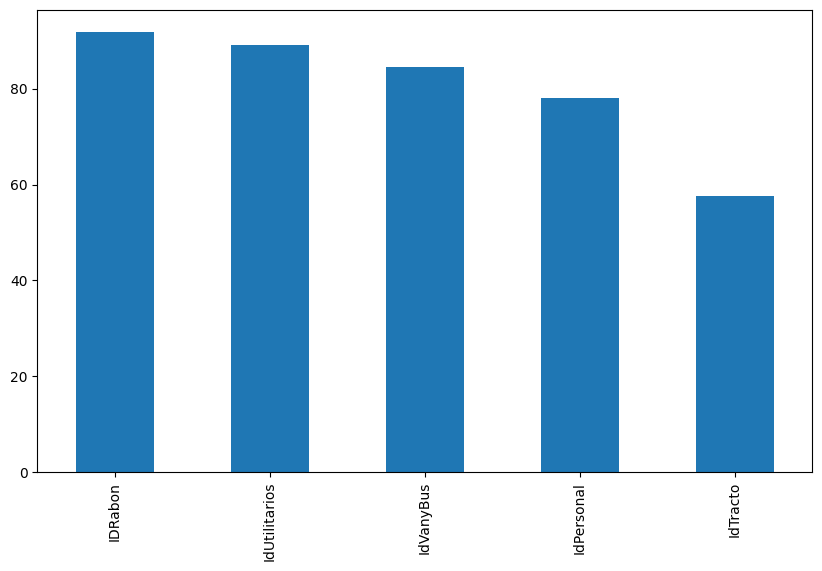

In [ ]:
# Visualización de Nulos de manera Grafica
plt.figure(figsize=(10,6))
serie.plot(kind='bar')

In [ ]:
# Instalar Librería missingno
!pip install missingno

<Axes: >

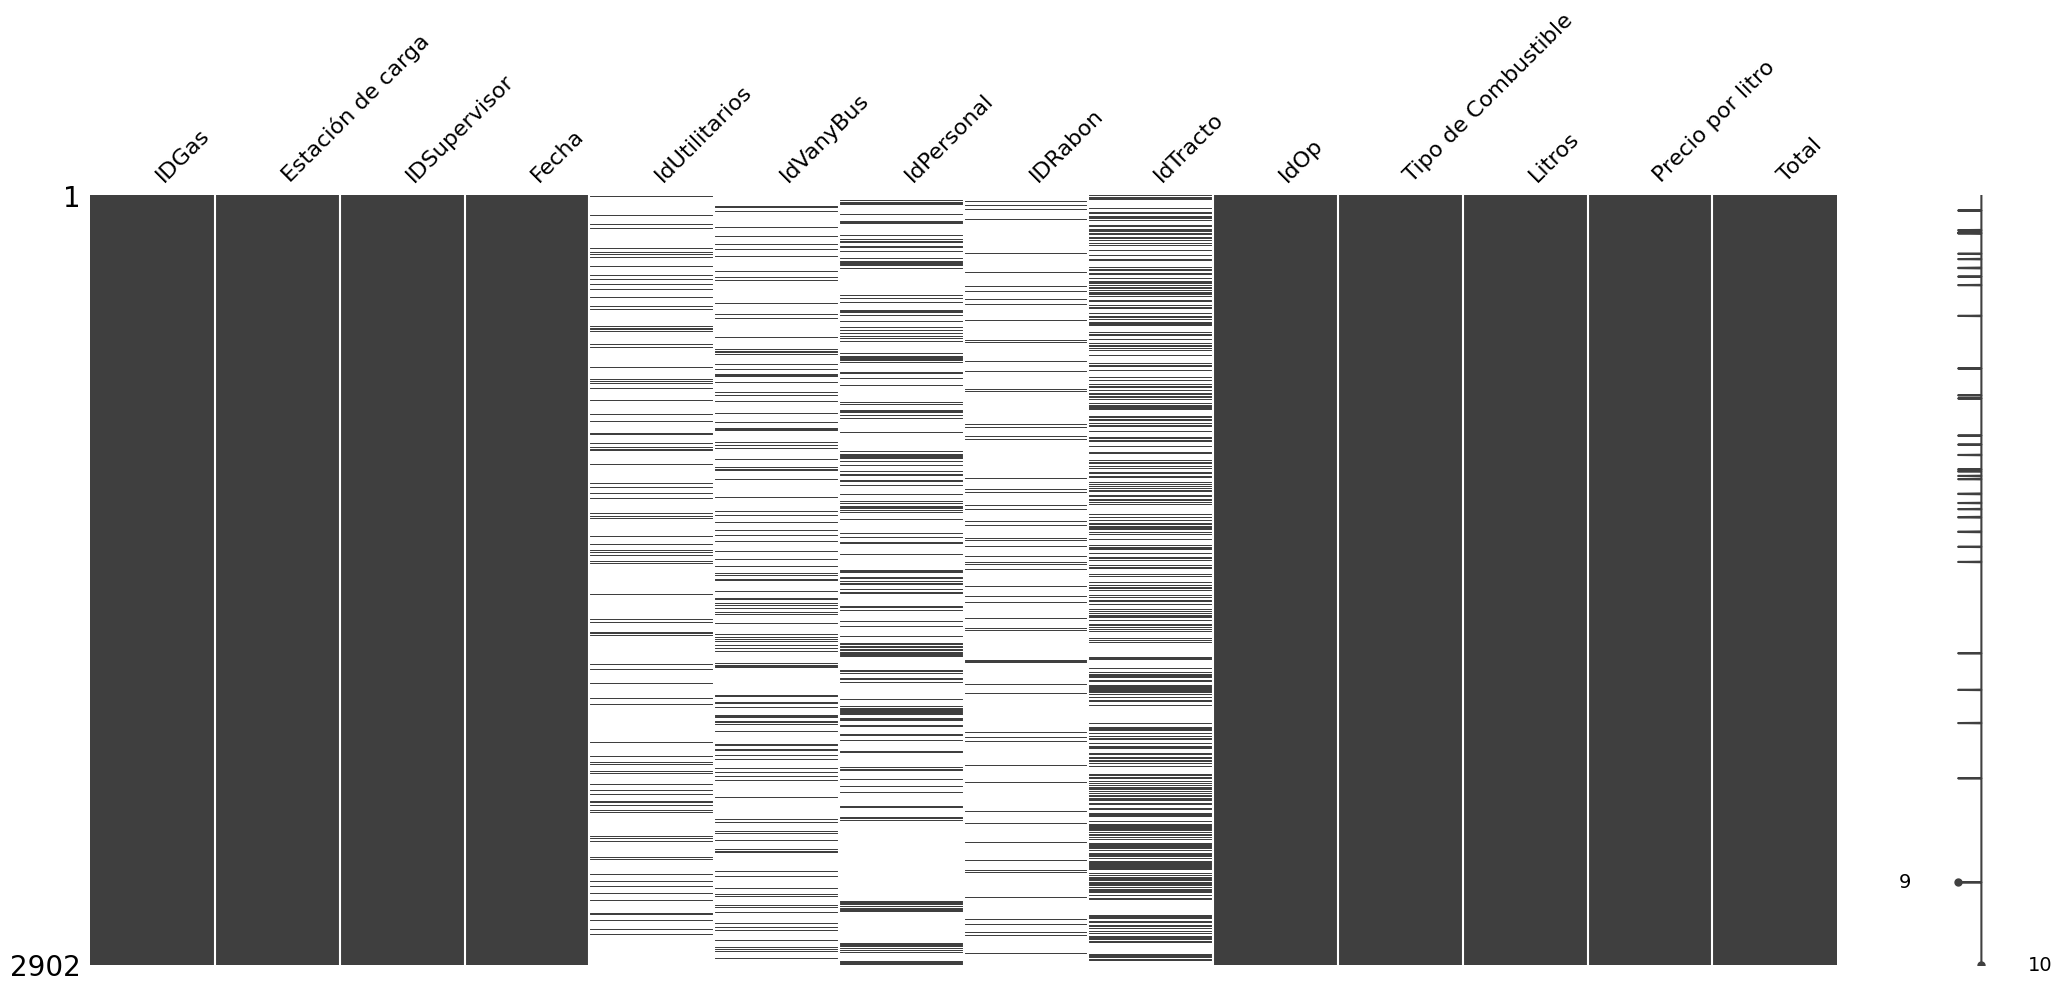

In [ ]:
import missingno as msno
msno.matrix(df)

<Axes: >

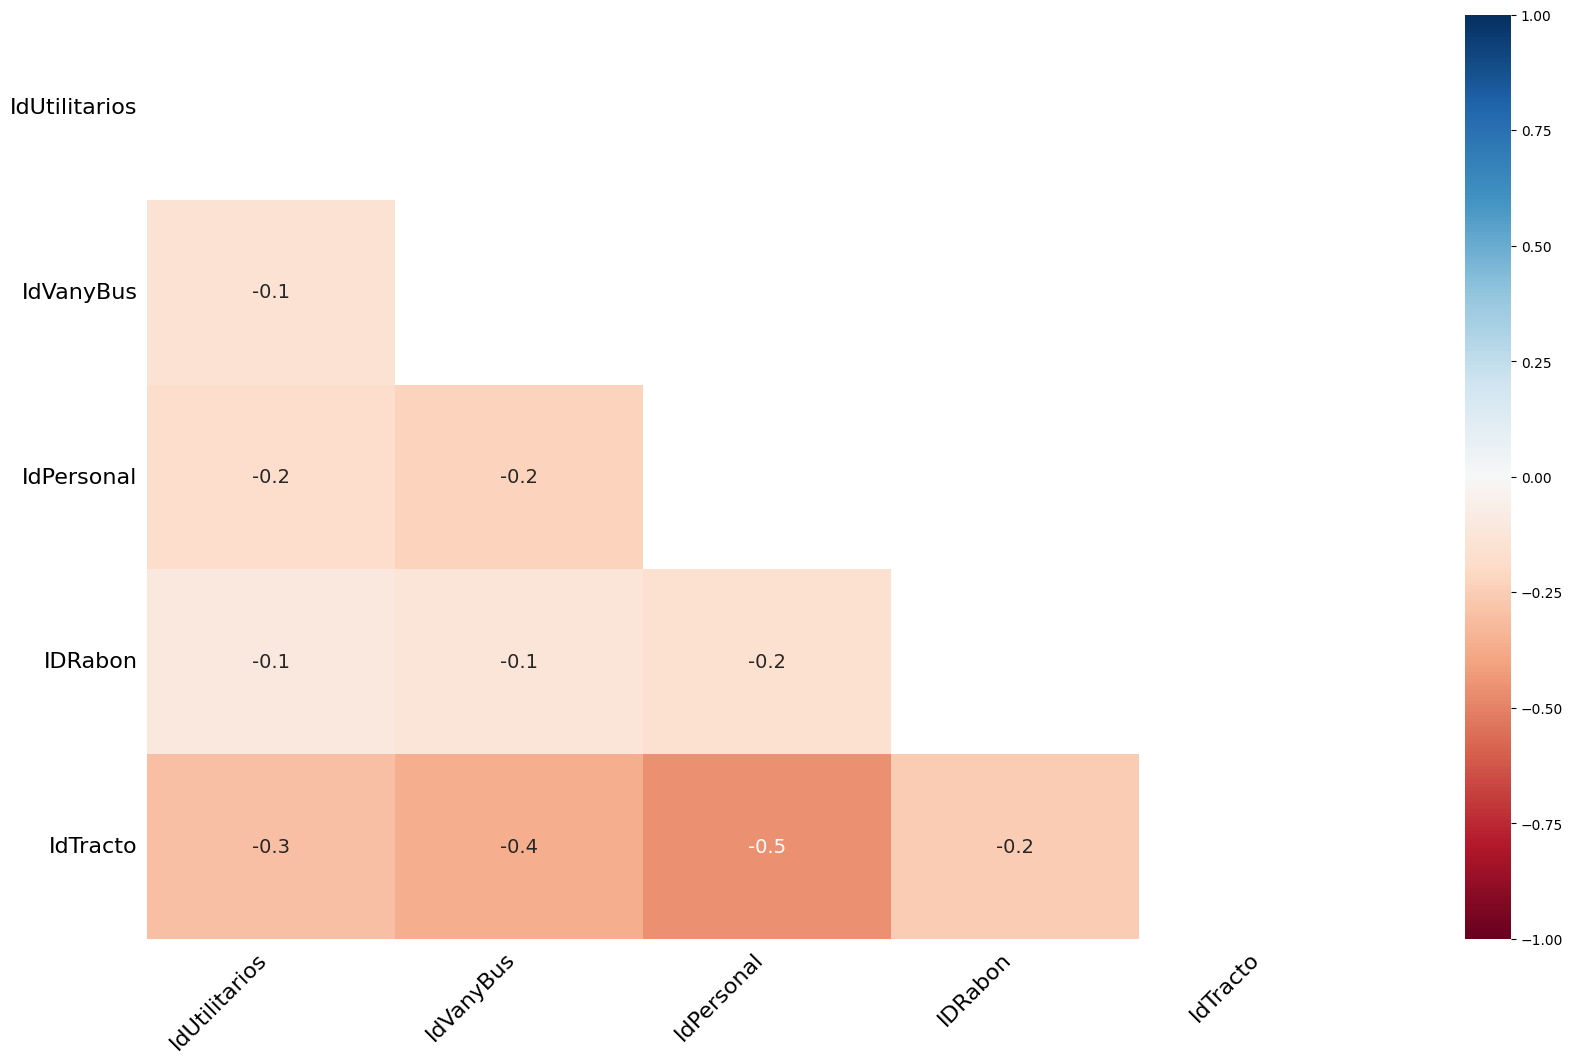

In [ ]:
msno.heatmap(df)

In [ ]:
# Al tratarse de variables numericas que representan valores categoricos que incluyen el ID de la unidad
# Podemos rellenar con " " los valores nulos ya que no se utlizaran para ningun calculo
# IMPORTANTE: No eliminare ningun NAN porque eliminaria todos los datos del Data Frame
df2 = df.fillna('')
df2.head(5)

,IDGas,Estación de carga,IDSupervisor,Fecha,IdUtilitarios,IdVanyBus,IdPersonal,IDRabon,IdTracto,IdOp,Tipo de Combustible,Litros,Precio por litro,Total
0,1,ALEJO PUEBLA,5,25/07/2022,,,,,7.0,60,Diesel,95,22.99,2184.05
1,2,ALEJO PUEBLA,5,25/07/2022,,,,,32.0,BAJA,Diesel,760,22.99,17472.40
2,3,ALEJO PUEBLA,2,25/07/2022,,14.0,,,,43,Diesel,65,22.99,1494.35
3,4,ALEJO PUEBLA,2,25/07/2022,,,2.0,,,36,Diesel,120,22.99,2758.80
4,5,ALEJO PUEBLA,5,25/07/2022,,,,,35.0,BAJA,Diesel,850,22.99,19541.50


In [ ]:
# Cambiar tipo de dato con .astype
df2[['IdUtilitarios','IdVanyBus', 'IdPersonal', 'IDRabon', 'IdTracto', 'IdOp']].astype(str)
df2.head(5)

,IDGas,Estación de carga,IDSupervisor,Fecha,IdUtilitarios,IdVanyBus,IdPersonal,IDRabon,IdTracto,IdOp,Tipo de Combustible,Litros,Precio por litro,Total
0,1,ALEJO PUEBLA,5,25/07/2022,,,,,7.0,60,Diesel,95,22.99,2184.05
1,2,ALEJO PUEBLA,5,25/07/2022,,,,,32.0,BAJA,Diesel,760,22.99,17472.40
2,3,ALEJO PUEBLA,2,25/07/2022,,14.0,,,,43,Diesel,65,22.99,1494.35
3,4,ALEJO PUEBLA,2,25/07/2022,,,2.0,,,36,Diesel,120,22.99,2758.80
4,5,ALEJO PUEBLA,5,25/07/2022,,,,,35.0,BAJA,Diesel,850,22.99,19541.50


In [ ]:
df2.dtypes

Total    float64
dtype: object

# **Storytelling contexto en General**

"Optimizando la Eficiencia: Transformando el Transporte"

**Introducción:**
Bienvenidos a esta sesión de revisión de números en la carga de hidrocarburos, donde exploraremos los datos detrás de nuestra empresa para desentrañar secretos ocultos y oportunidades de mejora. Sumérgete en esta narrativa numérica mientras respondemos preguntas clave sobre nuestro consumo de combustible, estaciones de carga, segmentos de transporte y autorizaciones de supervisores.

**¿Qué unidades están consumiendo más combustible?**

Nuestra historia comienza al observar las unidades que están generando una mayor sed de combustible. Mediante análisis detallados de nuestros registros de consumo, hemos identificado a las unidades que requieren una mayor eficiencia. Estas unidades, a pesar de su alto consumo, nos ofrecen una oportunidad única para mejorar. A través de programas de mantenimiento preventivo y la implementación de tecnologías de control de consumo, estamos comprometidos en reducir sus necesidades de combustible, impulsando la sostenibilidad y eficiencia.

A continuación analizaremos cada segmento de transporte de la empresa para revisar el consumo de combustible de cada unidad

# **StoryTelling de Utilitarios**

Los utilitarios son unidades chicas, que se ocupan principalmente para el transporte de supervisores, directores, mecánicos y electricistas.

In [ ]:
dfUti = pdDataFrame = df[['Fecha', 'IdUtilitarios', 'Tipo de Combustible', 'Litros', 'Total']].dropna()
dfUti.head(5)

,Fecha,IdUtilitarios,Tipo de Combustible,Litros,Total
5,25/07/2022,1.0,Gasolina,50,1174.5
59,26/07/2022,7.0,Gasolina,40,851.6
75,27/07/2022,11.0,Gasolina,40,851.6
77,27/07/2022,15.0,Gasolina,50,1064.5
90,28/07/2022,16.0,Gasolina,40,851.6


In [ ]:
# Consumo Total del segmento de Utilitarios: $293,174.57
datauti['Total'].sum()

293174.57000000007

In [ ]:
# Eventos Totales de cargas de combustible en los Utilitarios
datauti['IdUtilitarios'].count()

316

En el siguiente Histograma podemos revisar que la mayoria de las unidades del segmento de utilitarios carga un promedio de 800 a 850 pesos por cada carga.

<ipython-input-36-35e8a4731613>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfUti['Total'])


<Axes: xlabel='Total', ylabel='Density'>

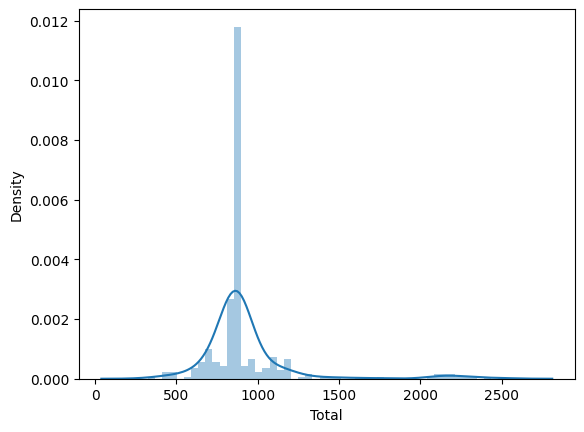

In [ ]:
sns.distplot(dfUti['Total'])
# Limite del total: 2500

In [ ]:
# Importe consumido de cada carga de las unidades del segmento de utilitarios
var = 'IdUtilitarios'
datauti = pd.concat([dfUti[var], dfUti['Total']], axis = 1)
datauti.head()

,IdUtilitarios,Total
5,1.0,1174.5
59,7.0,851.6
75,11.0,851.6
77,15.0,1064.5
90,16.0,851.6


In [ ]:
datauti.shape

(316, 2)

(-0.5, 23.5, 0.0, 2700.0)

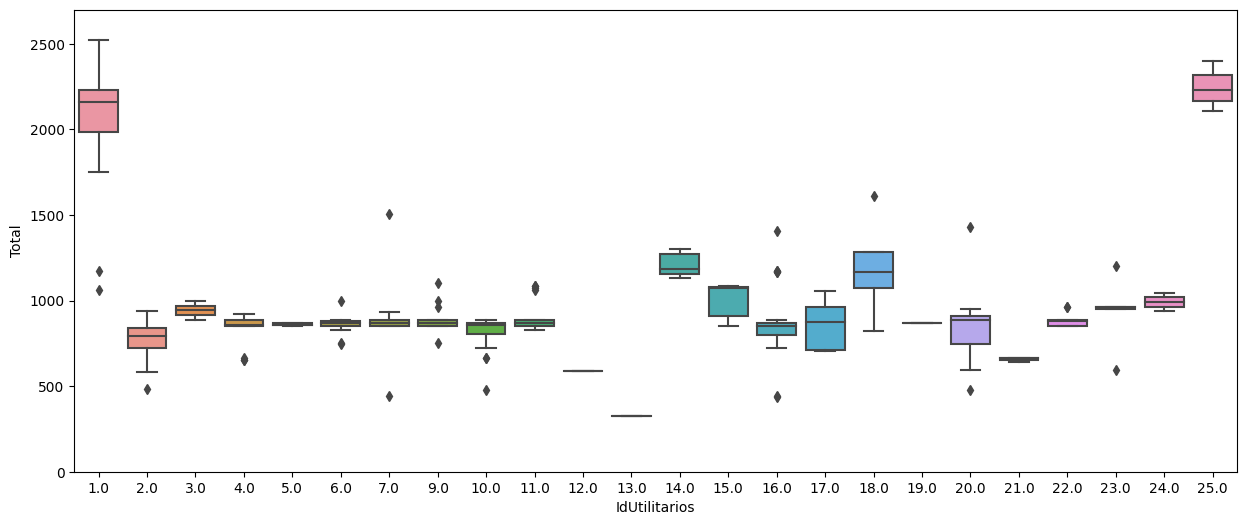

In [ ]:
# Valores atipicos en las cargas de combustible de los utilitarios
f, ax = plt.subplots(figsize = (15,6))
fig = sns.boxplot(x = var, y = 'Total', data = datauti)
fig.axis(ymin = 0, ymax = 2700)

Revisamos la suma total de combustible consumido por cada unidad

In [ ]:
# Importe total de combustible a unidades del segmento de utilitarios
sumuti = dfUti[['IdUtilitarios', 'Total']].groupby(by = 'IdUtilitarios').sum()
sumuti.head(7)

,Total
IdUtilitarios,
1.0,24012.22
2.0,25199.52
3.0,1885.86
4.0,21129.70
5.0,6025.20
6.0,20738.75
7.0,32446.85


In [ ]:
sumuti.shape

(24, 1)

<Axes: xlabel='IdUtilitarios'>

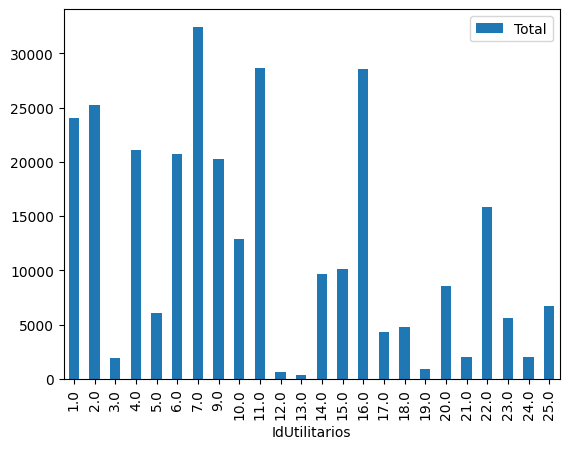

In [ ]:
sumuti.plot.bar()

En conclusión podemos asegurar que las unidades 1 y 25 tienen cargas atípicas que necesitan ser revisadas con su operación logistica, mientras que las unidades 7, 11 y 16, son las unidades que más combustible cargan, esto debido a que son unidades que se utilizan para el rescate de unidades accidentadas o descompuestas.

# **StoryTelling de Vanes y Buses**

Las Vanes y Buses son unidades que trabajan en el rubro de turismo, teniendo unidades de 14, 21, 45 y 51 pasajeros, estas unidades se encuentran principalmente al servicio de agencias de turismo y escuelas, recorren practicamente todo el país, principalmente el sureste del país como Cancun, Acapulco y Oaxaca.

In [ ]:
dfVanB = pdDataframe = df[['Fecha', 'IdVanyBus', 'Tipo de Combustible', 'Litros', 'Total']].dropna()
dfVanB.head(5)

,Fecha,IdVanyBus,Tipo de Combustible,Litros,Total
2,25/07/2022,14.0,Diesel,65,1494.35
6,25/07/2022,16.0,Gasolina,55,1166.00
36,26/07/2022,12.0,Gasolina,50,1064.50
43,26/07/2022,13.0,Diesel,65,1494.35
47,26/07/2022,3.0,Diesel,225,5172.75


In [ ]:
# Consumo Total del segmento de Vanes y Buses: $957,665.29
dfVanB['Total'].sum()

957665.29

En el siguiente Histograma podemos revisar que la mayoria de las unidades del segmento de Vanes y Buses carga un promedio de 1250 pesos por cada carga.

<ipython-input-24-6f87a241cf2e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfVanB['Total'])


<Axes: xlabel='Total', ylabel='Density'>

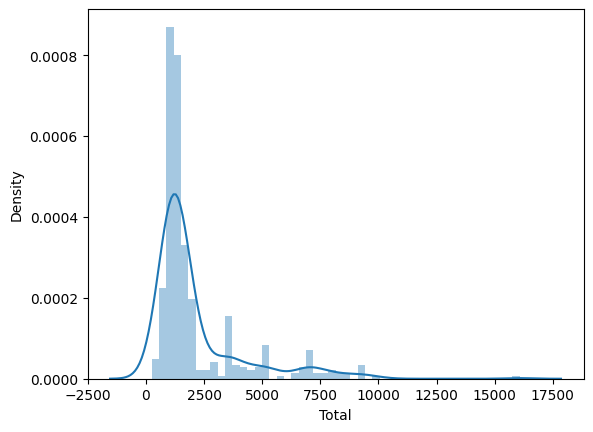

In [ ]:
sns.distplot(dfVanB['Total'])
# Limite del total: 17500

In [ ]:
# Importe consumido de cada carga de las unidades del segmento de Vanes y Buses
var = 'IdVanyBus'
dataVB = pd.concat([dfVanB[var], dfVanB['Total']], axis = 1)
dataVB.head()

,IdVanyBus,Total
2,14.0,1494.35
6,16.0,1166.00
36,12.0,1064.50
43,13.0,1494.35
47,3.0,5172.75


In [ ]:
dataVB.shape

(450, 2)

(-0.5, 21.5, 0.0, 18000.0)

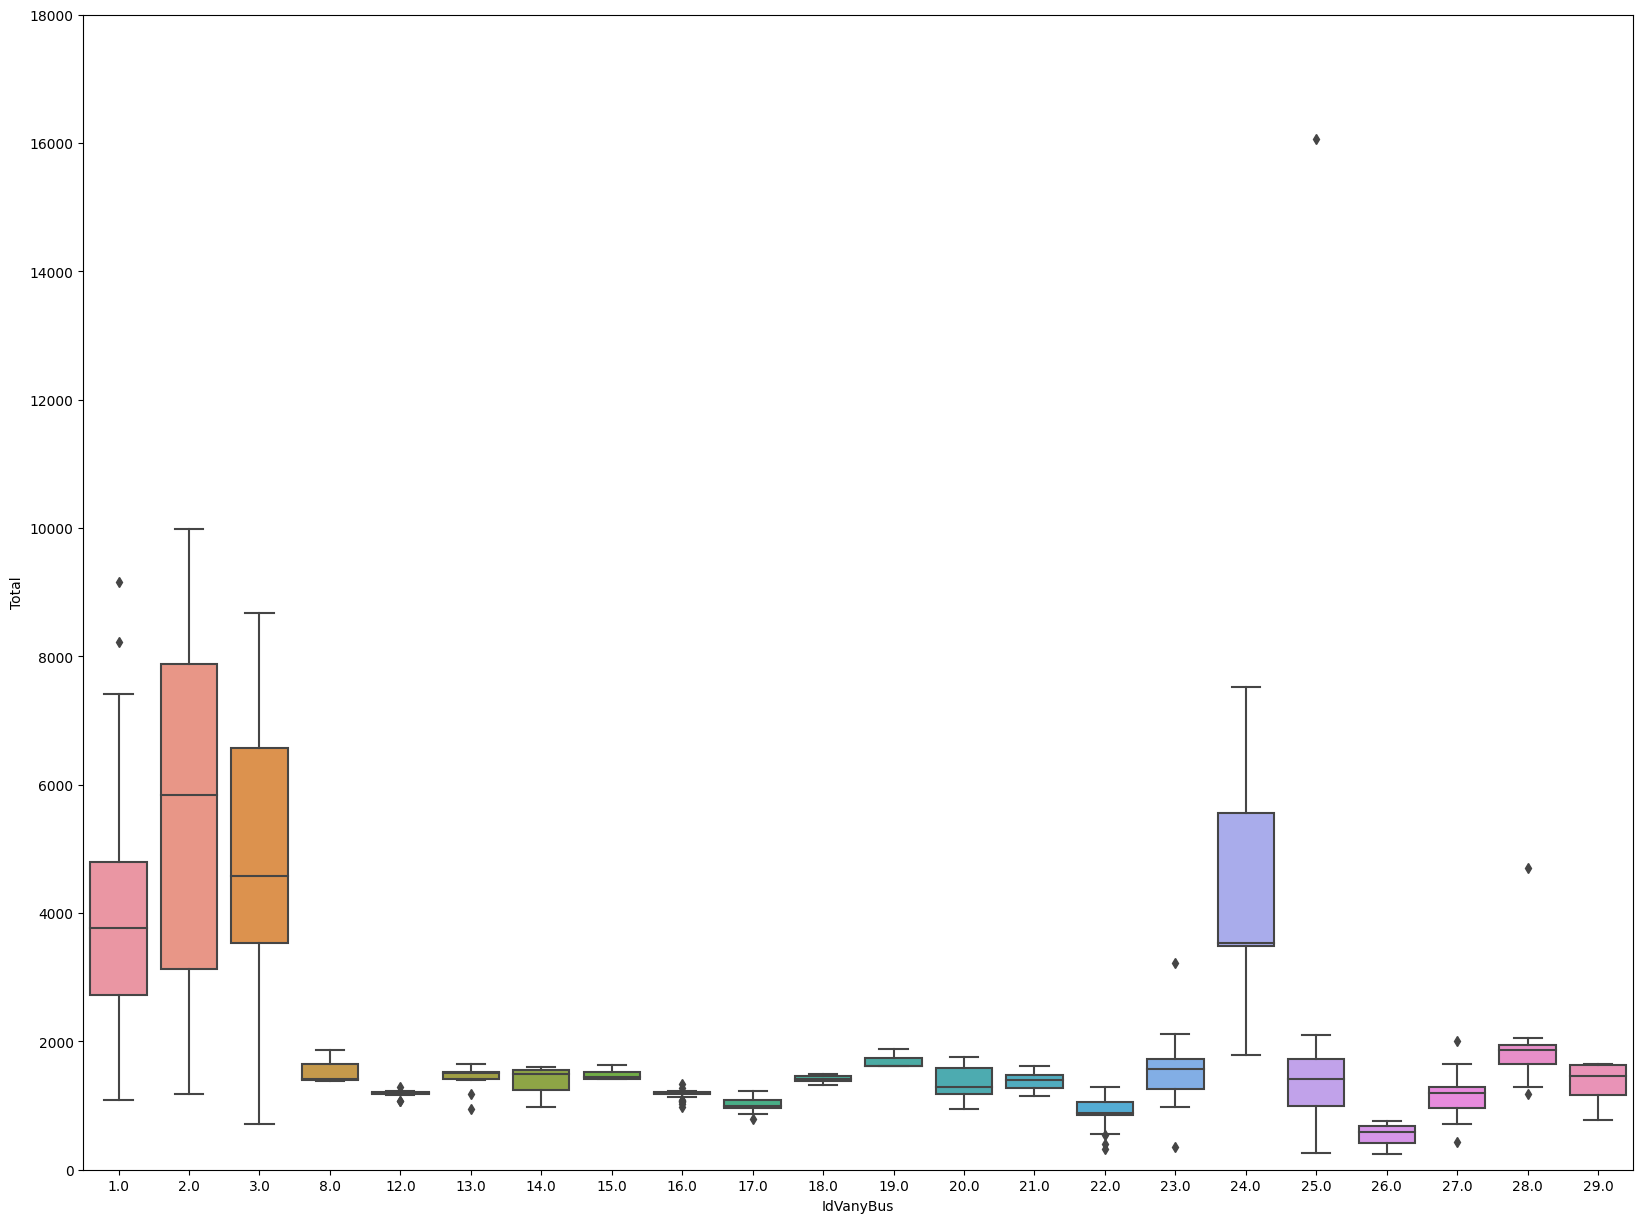

In [ ]:
# Valores atipicos en las cargas de combustible de las Vanes y Buses
f, ax = plt.subplots(figsize = (20,15)) #Define el area donde se va a graficar, 15 y 6 es el tamaño que queremos
fig = sns.boxplot(x = var, y = 'Total', data = dataVB) #Armamos los valores del gráfico
fig.axis(ymin = 0, ymax = 18000) #Valores maximos y minimos mostrados en el grafico en el eje y

Revisamos la suma total de combustible consumido por cada unidad

In [ ]:
# Importe total de combustible a unidades del segmento de Vanes y buses
sumVB = dfVanB[['IdVanyBus', 'Total']].groupby(by = 'IdVanyBus').sum()
sumVB.head(7)

,Total
IdVanyBus,
1.0,92825.62
2.0,150112.61
3.0,186909.15
8.0,4661.20
12.0,48815.90
13.0,21721.68
14.0,4069.08


In [ ]:
sumVB.shape

(22, 1)

<Axes: xlabel='IdVanyBus'>

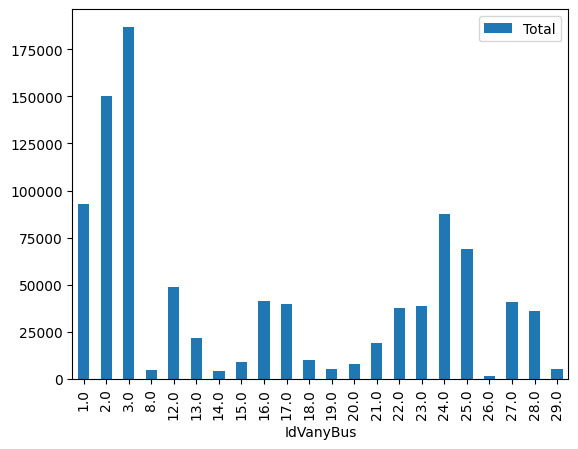

In [ ]:
sumVB.plot.bar()

Revisando los números del segmento de Vanes y Buses, llego a la conclusión de que hay una carga atípica y descarada en la unidad 25, en la cual deberiamos analizar de manera detenida porque estoy seguro que se recurrio al robo de hidrocarburos con esta unidad, además de que las unidades 23 y 28 tambien tienen valores atípicos, las unidades con más consumo de combustible son la 2 y 3 las cuales corresponden a unidades de de 51 pasajeros, por lo cual su consumo es normal.

# **StoryTelling del Transporte de Personal**

El transporte de personal es el segundo segmento más importante de la empresa, brindamos el servicio de transporte a empresas transnacionales con un alto número de empleados que recorren largas distancias para llegar a su fuente de trabajo, el transporte de personal esta dividido en rutas establecidas en común acuerdo con las empresas, diariamente se recorren las rutas en 3 turnos al día.

Las unidades utilizadas tienen una capacidad de carga para 40, 22, y 12 personas.

In [ ]:
dfPer = pdDataframe = df[['Fecha', 'IdPersonal', 'Tipo de Combustible', 'Litros', 'Total']].dropna()
dfPer.head(5)

,Fecha,IdPersonal,Tipo de Combustible,Litros,Total
3,25/07/2022,2.0,Diesel,120,2758.80
10,25/07/2022,10.0,Diesel,130,2988.70
15,25/07/2022,6.0,Diesel,135,3103.65
17,25/07/2022,11.0,Diesel,150,3448.50
18,25/07/2022,21.0,Diesel,160,3678.40


In [ ]:
dataPer['Total'].sum()

2109041.29

In [ ]:
dfPer.shape

(635, 5)

En el siguiente Histograma podemos revisar que la mayoria de las unidades del segmento de Transporte de Personal carga un promedio de 4000 pesos por cada carga.

<ipython-input-34-3ec88732b6b4>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfPer['Total'])


<Axes: xlabel='Total', ylabel='Density'>

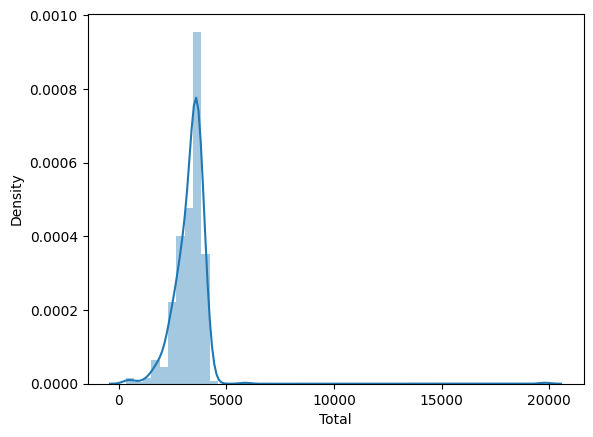

In [ ]:
sns.distplot(dfPer['Total'])
# Limite del total: 20000

In [ ]:
# Importe consumido de cada carga de las unidades del segmento del Transporte de Personal
var = 'IdPersonal'
dataPer = pd.concat([dfPer[var], dfPer['Total']], axis = 1)
dataPer.head()

,IdPersonal,Total
3,2.0,2758.80
10,10.0,2988.70
15,6.0,3103.65
17,11.0,3448.50
18,21.0,3678.40


In [ ]:
dataPer.shape

(635, 2)

(-0.5, 30.5, 0.0, 20000.0)

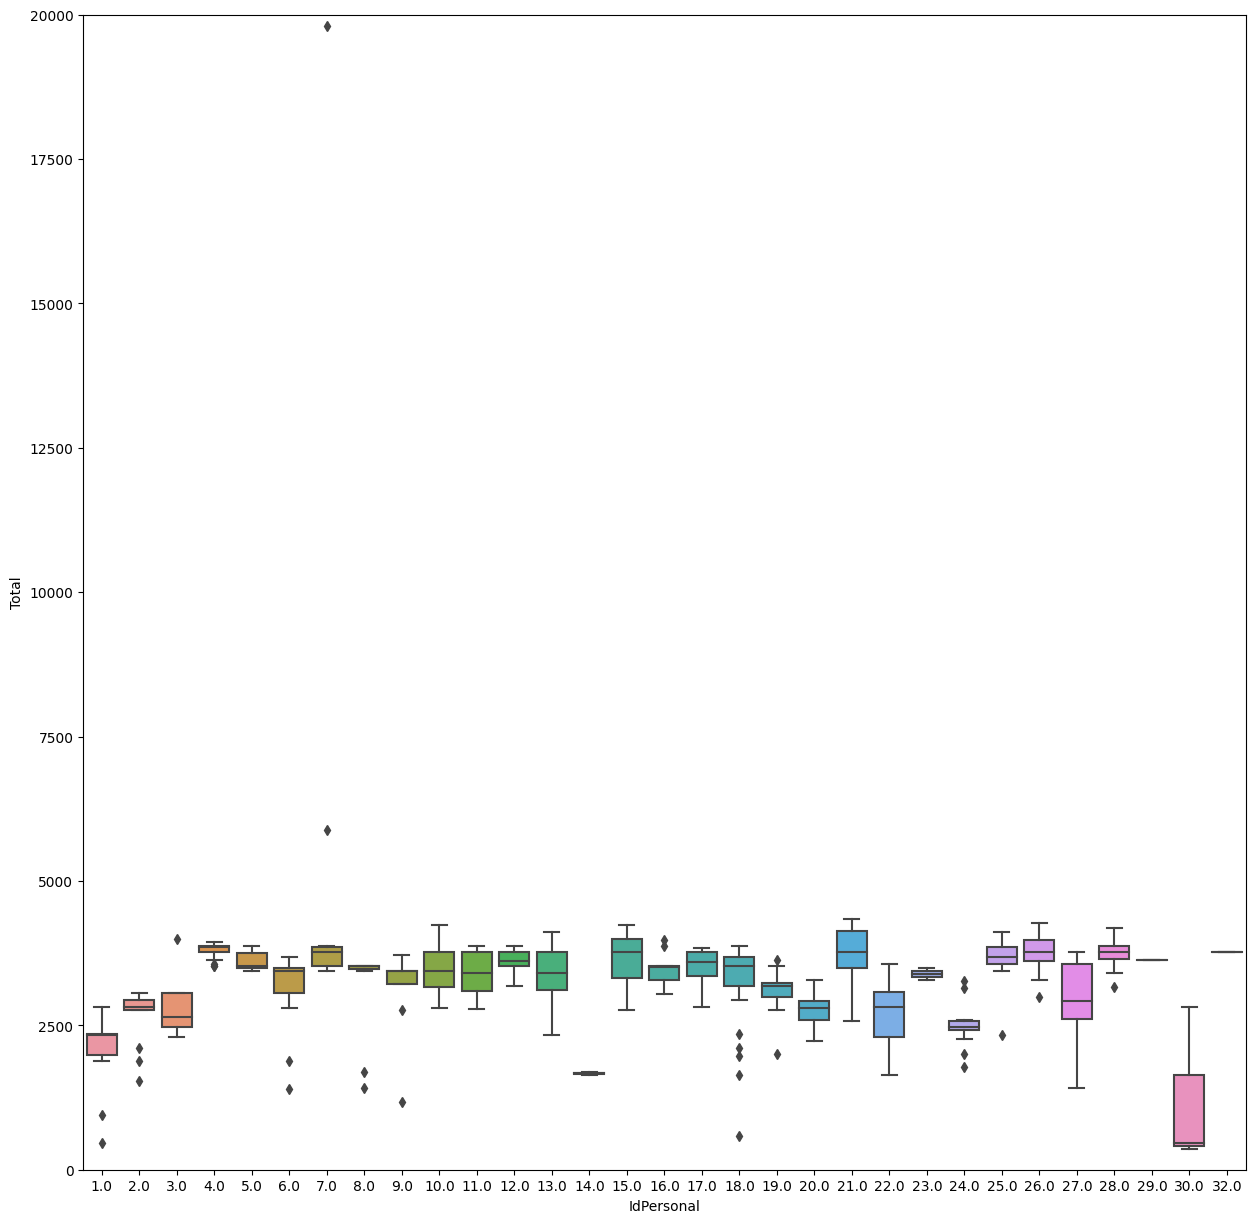

In [ ]:
# Valores atipicos en las cargas de combustible del transporte de personal
f, ax = plt.subplots(figsize = (15,15)) #Define el area donde se va a graficar, 15 y 6 es el tamaño que queremos
fig = sns.boxplot(x = var, y = 'Total', data = dataPer) #Armamos los valores del gráfico
fig.axis(ymin = 0, ymax = 20000) #Valores maximos y minimos mostrados en el grafico en el eje y

**Revisamos la suma total de combustible consumido por cada unidad**

In [ ]:
# Importe total de combustible a unidades del segmento de Transporte de personal
sumPer = dfPer[['IdPersonal', 'Total']].groupby(by = 'IdPersonal').sum()
sumPer.head()

,Total
IdPersonal,
1.0,29456.20
2.0,77684.55
3.0,11583.40
4.0,118287.38
5.0,104527.03


In [ ]:
sumPer.shape

(31, 1)

<Axes: xlabel='IdPersonal'>

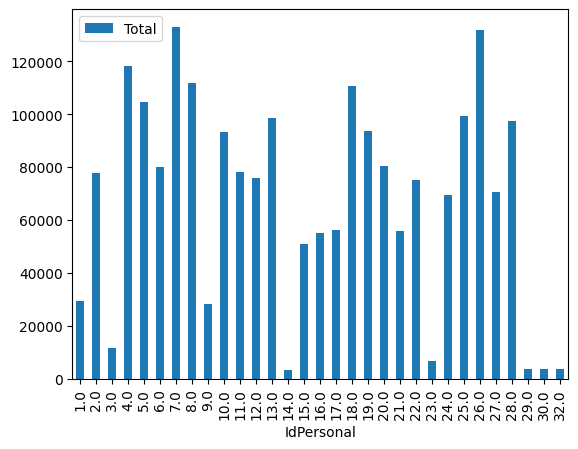

In [ ]:
sumPer.plot.bar()

Analizando el segmento de transporte de personal encontramos valores atípicos bastante sospechosos, en la unidad 7 encontramos una carga de 20,000 y una de casi 6,000, es seguro que el operador de esta unidad esta robando combustible y lo carga en tambos para revenderlo por otro lado, siendo esta unidad junto con la num 26, los que mayor combustible consumen.

# **StoryTelling de los Rabones**

Los rabones son unidades de carga semi pesada, se utilizan principalmente para realizar circuitos cortos, transportan principalmente partes automotrices, pero tambien transportan yeso y perecederos. Todas los circuitos se encuentran en un pequeño radio de entrega y por lo general realizan diversos stops en diferentes empresas antes de llegar a su destino final.

In [ ]:
dfRab = pdDataframe = df[['Fecha', 'IDRabon', 'Tipo de Combustible', 'Litros', 'Total']].dropna()
dfRab.head(5)

,Fecha,IDRabon,Tipo de Combustible,Litros,Total
7,25/07/2022,6.0,Diesel,100,2299.0
24,25/07/2022,3.0,Diesel,90,2069.1
37,26/07/2022,5.0,Diesel,130,2988.7
39,26/07/2022,4.0,Diesel,130,2988.7
45,26/07/2022,1.0,Diesel,90,2069.1


In [ ]:
# Consumo total de los Rabones
dataRab['Total'].sum()

650730.7

<ipython-input-42-eebd32c662d5>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfRab['Total'])


<Axes: xlabel='Total', ylabel='Density'>

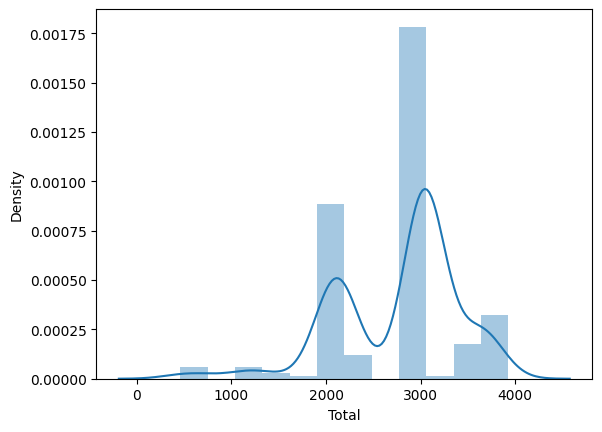

In [ ]:
sns.distplot(dfRab['Total'])
# Limite del total: 5000

In [ ]:
# Importe consumido de cada carga de las unidades del segmento de Rabones
var = 'IDRabon'
dataRab = pd.concat([dfRab[var], dfRab['Total']], axis = 1)
dataRab.head()

,IDRabon,Total
7,6.0,2299.0
24,3.0,2069.1
37,5.0,2988.7
39,4.0,2988.7
45,1.0,2069.1


In [ ]:
dataRab.shape

(235, 2)

(-0.5, 6.5, 0.0, 5000.0)

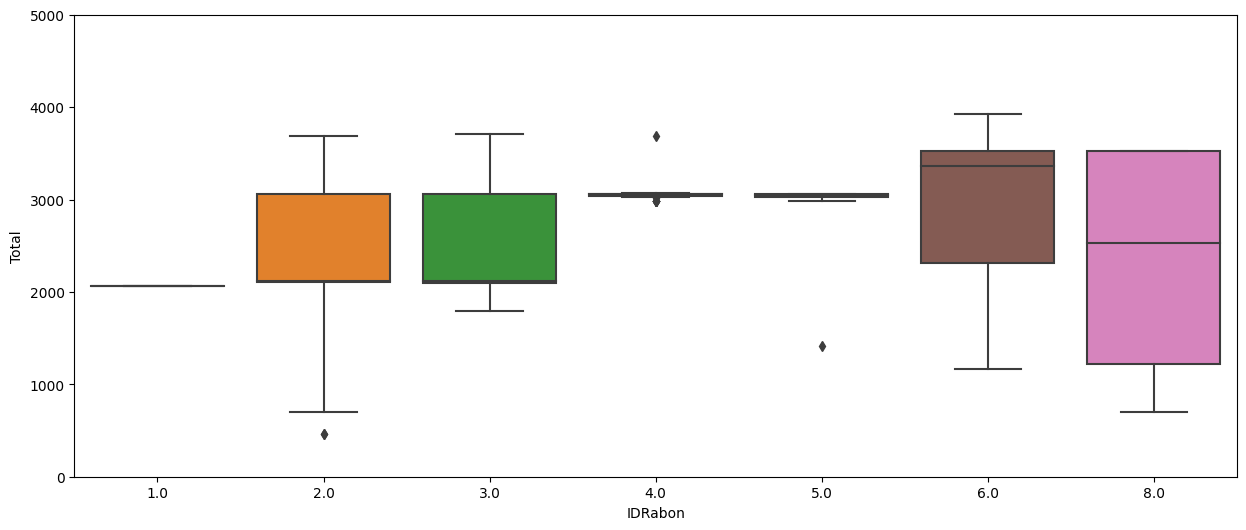

In [ ]:
# Valores atipicos en las cargas de combustible de los Rabones
f, ax = plt.subplots(figsize = (15,6)) #Define el area donde se va a graficar, 15 y 6 es el tamaño que queremos
fig = sns.boxplot(x = var, y = 'Total', data = dataRab) #Armamos los valores del gráfico
fig.axis(ymin = 0, ymax = 5000) #Valores maximos y minimos mostrados en el grafico en el eje y

Revisamos la suma total de combustible consumido por cada unidad

In [ ]:
# Importe total de combustible a unidades del segmento de Rabones
sumRab = dfRab[['IDRabon', 'Total']].groupby(by = 'IDRabon').sum()
sumRab.head(7)

,Total
IDRabon,
1.0,10345.50
2.0,107562.87
3.0,123804.30
4.0,167938.76
5.0,162533.90
6.0,54968.47
8.0,23576.90


In [ ]:
sumRab.shape

(7, 1)

<Axes: xlabel='IDRabon'>

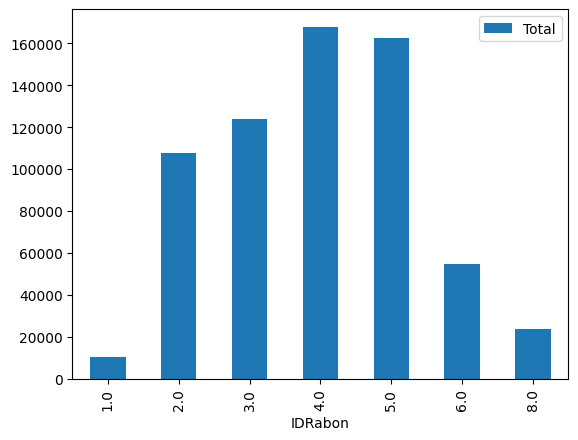

In [ ]:
sumRab.plot.bar()

Al tratarse de circuitos cortos y pocas unidades, el control de combustible es optimo, no se encuentran outliers que puedan significar robo de combustible.

# **StoryTelling de los Tractocamiones**

El segmento de los Tractocamiones representa el 77 porciento de la operación logistíca de la empresa, siendo la principal fuente de ingresos y de inversión, el cuidado que se debe de tener al revisar los datos de este segmento debe ser preciso, por que debido al número de unidades,  y que los servicios que se ejecutan son a grandes distancias, el intento de robo de combustible crece de manera exponencial.

In [ ]:
dfTra = pdDataFrame = df[['Fecha', 'IdTracto', 'Tipo de Combustible', 'Litros', 'Total']].dropna()
dfTra.head(5)

,Fecha,IdTracto,Tipo de Combustible,Litros,Total
0,25/07/2022,7.0,Diesel,95,2184.05
1,25/07/2022,32.0,Diesel,760,17472.40
4,25/07/2022,35.0,Diesel,850,19541.50
8,25/07/2022,36.0,Diesel,60,1379.40
9,25/07/2022,20.0,Diesel,900,20691.00


In [ ]:
# Consumo Total del segmento de Tractocamiones $13,277,607.35
dataTra['Total'].sum()

13277607.350000001

<ipython-input-52-cb9e5831b905>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfTra['Total'])


<Axes: xlabel='Total', ylabel='Density'>

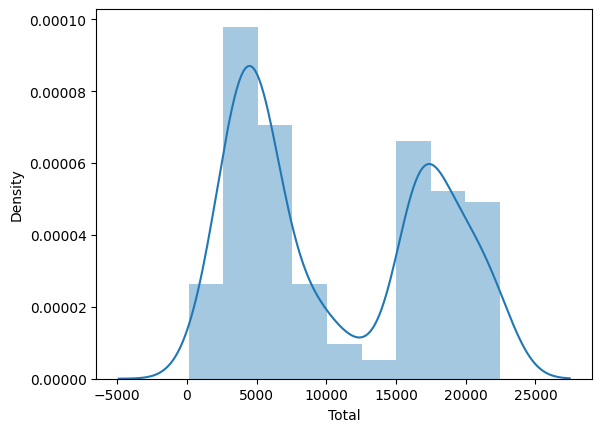

In [ ]:
sns.distplot(dfTra['Total'])
# Limite del total: 25000

In [ ]:
# Importe consumido de cada carga de las unidades del segmento de Tractocamiones
var = 'IdTracto'
dataTra = pd.concat([dfTra[var], dfTra['Total']], axis = 1)
dataTra.head()

,IdTracto,Total
0,7.0,2184.05
1,32.0,17472.40
4,35.0,19541.50
8,36.0,1379.40
9,20.0,20691.00


In [ ]:
dataTra.shape

(1228, 2)

(-0.5, 42.5, 0.0, 28000.0)

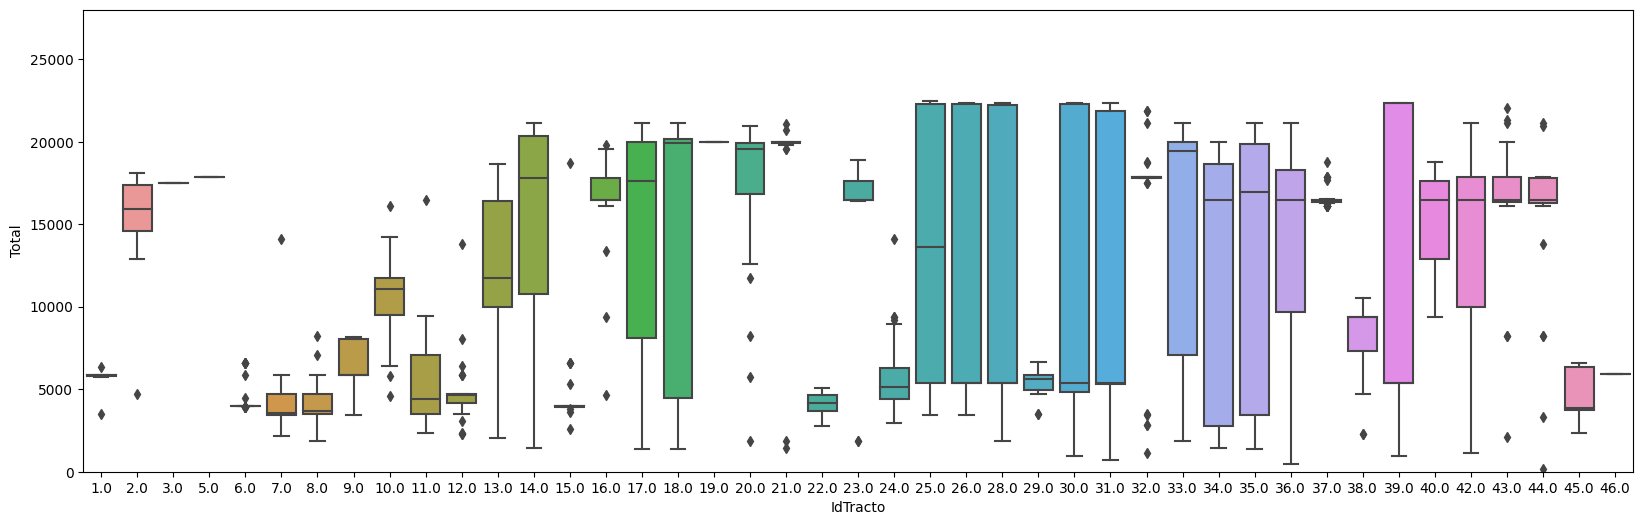

In [ ]:
# Valores atipicos en las cargas de combustible de los Tractocamiones
f, ax = plt.subplots(figsize = (20,6)) #Define el area donde se va a graficar, 15 y 6 es el tamaño que queremos
fig = sns.boxplot(x = var, y = 'Total', data = dataTra) #Armamos los valores del gráfico
fig.axis(ymin = 0, ymax = 28000) #Valores maximos y minimos mostrados en el grafico en el eje y

Revisamos la suma total de combustible consumido por cada unidad

In [ ]:
# Importe total de combustible a unidades del segmento de Tractocamiones
sumTra = dfTra[['IdTracto', 'Total']].groupby(by = 'IdTracto').sum()
sumTra.head(7)

,Total
IdTracto,
1.0,237936.20
2.0,322555.58
3.0,17472.40
5.0,17867.60
6.0,186344.40
7.0,149007.15
8.0,178176.45


In [ ]:
sumTra.shape

(43, 1)

<Axes: xlabel='IdTracto'>

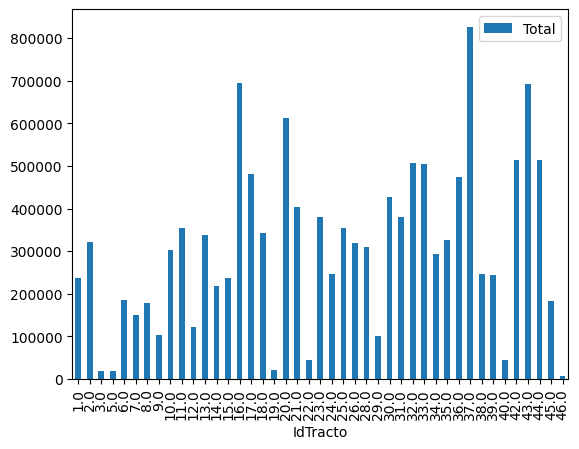

In [ ]:
sumTra.plot.bar()

Sorpresivamente el segmento de Tractocamiones no presenta datos atípicos, al contrario, demuestra un standard en las cargas de combustible, que de acuerdo al especialista del negocio, las unidades con más cargas de hidrocarburo, son las que realizan viajes más largos, y que las unidades con menos consumo, son unidades que estuvierón un tiempo en el taller de reparación.

# **StoryTelling de Estaciones de combustible**

**¿Qué estaciones de hidrocarburos cargan más combustible?**

En nuestra travesía, no podíamos pasar por alto las estaciones de carga que se destacan en nuestras estadísticas. Al investigar, hemos descubierto que ciertas estaciones están registrando volúmenes de carga más altos que otras. Utilizando estos datos, hemos establecido alianzas estratégicas con estas estaciones para negociar precios más competitivos y mejorar nuestra rentabilidad. Además, estamos explorando la posibilidad la instalación de estaciones de carga en colaboración con otras ubicaciones clave.



In [ ]:
dfEst = pdDataFrame = df[['Fecha', 'Estación de carga', 'Tipo de Combustible', 'Litros', 'Total']].dropna()
dfEst.head(5)

,Fecha,Estación de carga,Tipo de Combustible,Litros,Total
0,25/07/2022,ALEJO PUEBLA,Diesel,95,2184.05
1,25/07/2022,ALEJO PUEBLA,Diesel,760,17472.40
2,25/07/2022,ALEJO PUEBLA,Diesel,65,1494.35
3,25/07/2022,ALEJO PUEBLA,Diesel,120,2758.80
4,25/07/2022,ALEJO PUEBLA,Diesel,850,19541.50


In [ ]:
# Consumo total
dataEst['Total'].sum()

17544625.21

<ipython-input-62-951d25ae8956>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfEst['Total'])


<Axes: xlabel='Total', ylabel='Density'>

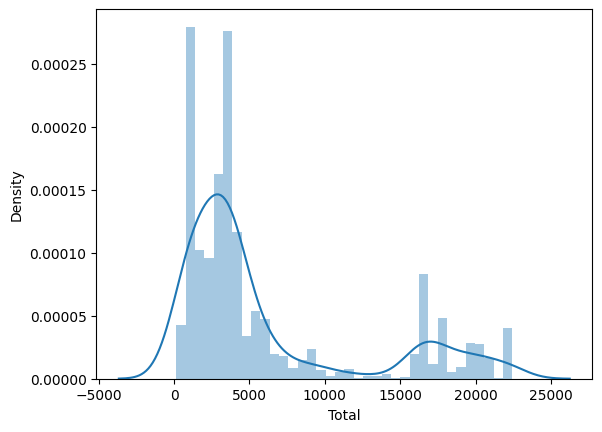

In [ ]:
sns.distplot(dfEst['Total'])
# Limite del total: 25000

In [ ]:
# Importe consumido en cada estación de carga
var = 'Estación de carga'
dataEst = pd.concat([dfEst[var], dfEst['Total']], axis = 1)
dataEst.head()

,Estación de carga,Total
0,ALEJO PUEBLA,2184.05
1,ALEJO PUEBLA,17472.40
2,ALEJO PUEBLA,1494.35
3,ALEJO PUEBLA,2758.80
4,ALEJO PUEBLA,19541.50


In [ ]:
dataEst.shape

(2902, 2)

(-0.5, 3.5, 0.0, 28000.0)

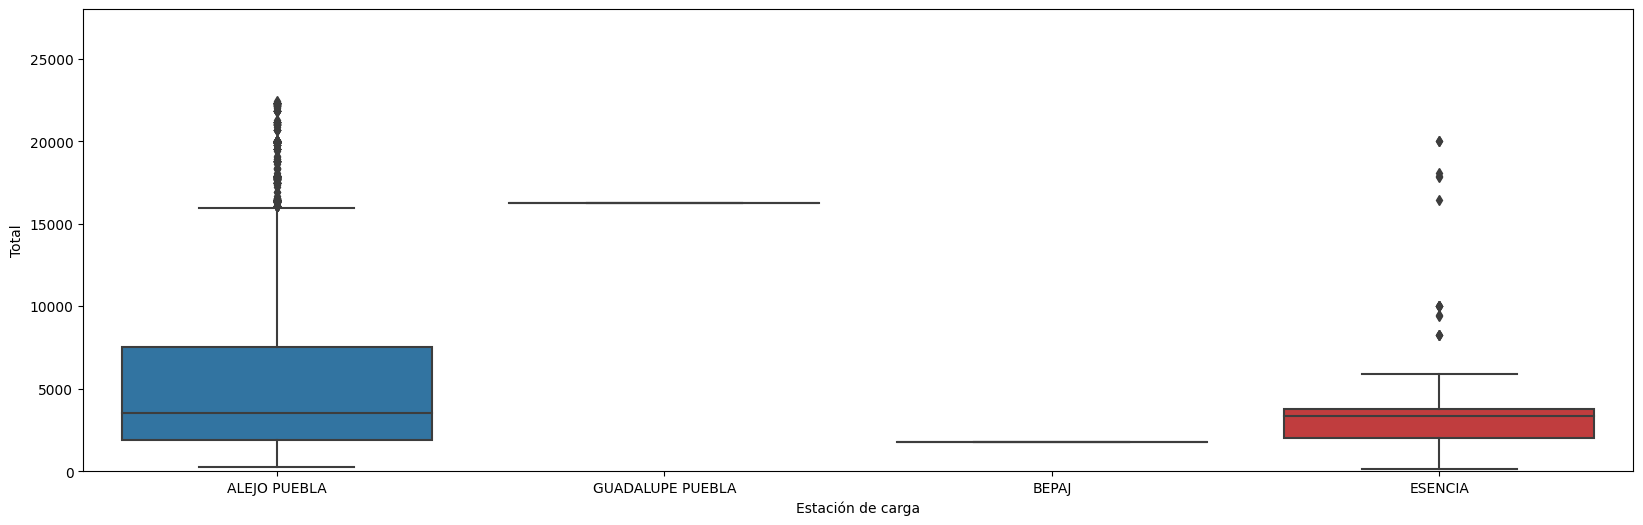

In [ ]:
# Valores atipicos en las cargas de combustible en las estaciones de carga
f, ax = plt.subplots(figsize = (20,6)) #Define el area donde se va a graficar, 15 y 6 es el tamaño que queremos
fig = sns.boxplot(x = var, y = 'Total', data = dataEst) #Armamos los valores del gráfico
fig.axis(ymin = 0, ymax = 28000) #Valores maximos y minimos mostrados en el grafico en el eje y

Revisamos la suma total de combustible consumido por cada estación de carga

In [ ]:
# Importe total de combustible cargado en cada estacion de hidrocarburos
sumEst = dfEst[['Estación de carga', 'Total']].groupby(by = 'Estación de carga').sum()
sumEst.head()

,Total
Estación de carga,
ALEJO PUEBLA,16452094.71
BEPAJ,1754.25
ESENCIA,1074543.25
GUADALUPE PUEBLA,16233.00


In [ ]:
sumEst.shape

(4, 1)

<Axes: xlabel='Estación de carga'>

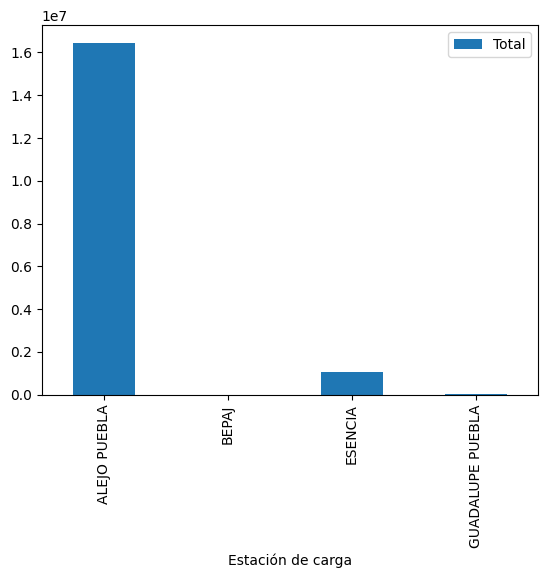

In [ ]:
sumEst.plot.bar()

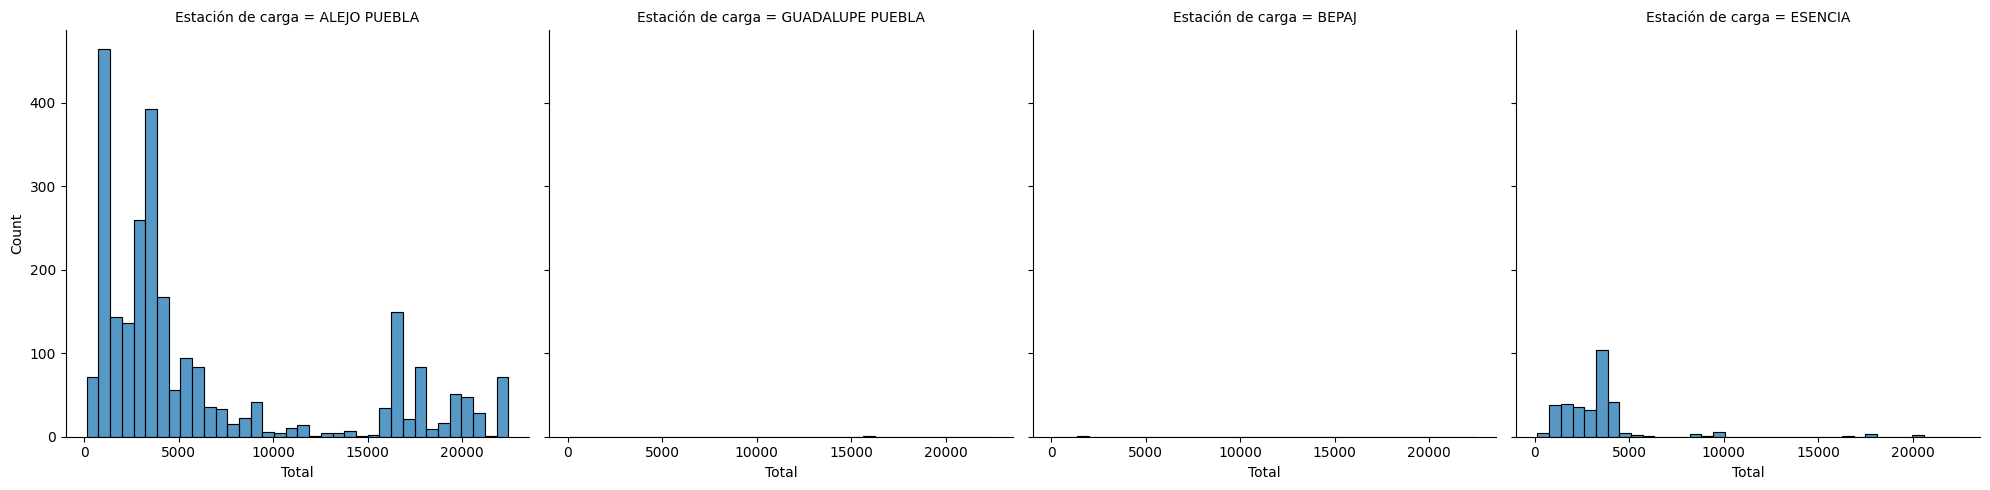

In [ ]:
#Consumo de combustible por estación de carga
sns.displot(data=dataEst,
            x="Total",
            col="Estación de carga")

**Conclusión:** Al tener un crédito activo en dos estaciones de carga, obviamente son en las que más se consume siendo 'Alejo Puebla' y 'Esencia' las gasolineras que mas consumo tienen, pero 'Alejo Puebla' al ser la gasolinera más cercana a los patios de resguardo de las unidades se consume mucho más, 'Bepaj' y 'Guadalupe Puebla' son estaciones de carga auxiliares.

# **StoryTelling ¿Qué segmentos del transporte consumen más combustible?**

En nuestro análisis, hemos desglosado los datos por segmentos de transporte. Descubrimos que los segmentos de carga pesada y entregas interurbanas son los que presentan un mayor consumo de combustible. Sin embargo, no estamos de brazos cruzados. Estamos diversificando nuestra flota al incluir vehículos más eficientes en estos segmentos y aprovechando la telemetría para optimizar las rutas y los métodos de conducción. Esto no solo reduce el consumo de combustible, sino que también aumenta la satisfacción del cliente al cumplir con los plazos de entrega.

In [ ]:
#Sustituyendo los valores de las categorías por los valores
categorias2 = [13277607.35, 2109041.29, 957665.29, 650730.7, 293174.57]
categorias2

[13277607.35, 2109041.29, 957665.29, 650730.7, 293174.57]

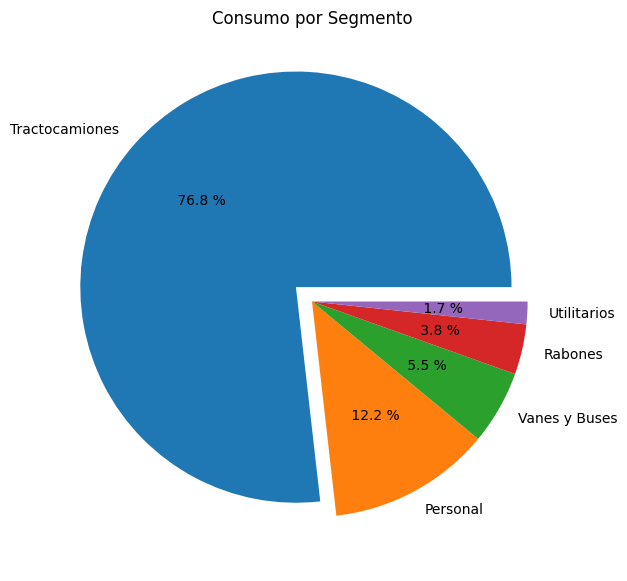

In [ ]:
fig,ax = plt.subplots(figsize =(10, 7))
segmentos = ['Tractocamiones', 'Personal', 'Vanes y Buses', 'Rabones', 'Utilitarios']
desfase = (0.1, 0, 0, 0, 0)
ax.pie(categorias2, labels = segmentos, autopct = '% 0.1f %%', explode = desfase)
ax.set_title('Consumo por Segmento')
plt.show()

En esta visualización podemos revisar el total de consumo de cada segmento del transporte, pudiendo identificar que el segmento de tractocamiones con un 76.8% es el que más consume combustible, el segmento de utilitarios al ser unidades
de rescate y al servicio de los supervisores el el que menos combustible consume con un total de 1.7% siendo estas las unidades que utilizan los supervisores como unidades de rescate cuando las unidades grandes llegan a descomponerse.

# **StoryTelling Supervisores**

En nuestra narrativa numérica, también miramos a nuestros supervisores que autorizan el consumo de combustible. Al identificar a aquellos que están generando autorizaciones más frecuentes, hemos implementado capacitación específica para mejorar su comprensión de la eficiencia en el consumo de combustible. Al mismo tiempo, estamos implementando procedimientos más rigurosos para garantizar que las autorizaciones sean coherentes con nuestras metas de optimización.

In [ ]:
dfSup = pdDataFrame = df[['Fecha', 'IDSupervisor', 'Tipo de Combustible', 'Litros', 'Total']].dropna()
dfSup.head()

,Fecha,IDSupervisor,Tipo de Combustible,Litros,Total
0,25/07/2022,5,Diesel,95,2184.05
1,25/07/2022,5,Diesel,760,17472.40
2,25/07/2022,2,Diesel,65,1494.35
3,25/07/2022,2,Diesel,120,2758.80
4,25/07/2022,5,Diesel,850,19541.50


<ipython-input-72-47fceda19159>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfSup['Total'])


<Axes: xlabel='Total', ylabel='Density'>

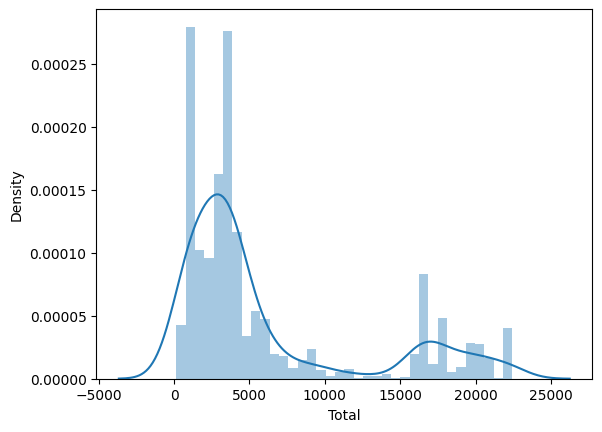

In [ ]:
sns.distplot(dfSup['Total'])
# Limite del total: 25000

In [ ]:
# Importe autorizado por cada supervisor
var = 'IDSupervisor'
dataSup = pd.concat([dfSup[var], dfSup['Total']], axis = 1)
dataSup.head()

,IDSupervisor,Total
0,5,2184.05
1,5,17472.40
2,2,1494.35
3,2,2758.80
4,5,19541.50


In [ ]:
dataSup.shape

(2902, 2)

(-0.5, 8.5, 0.0, 28000.0)

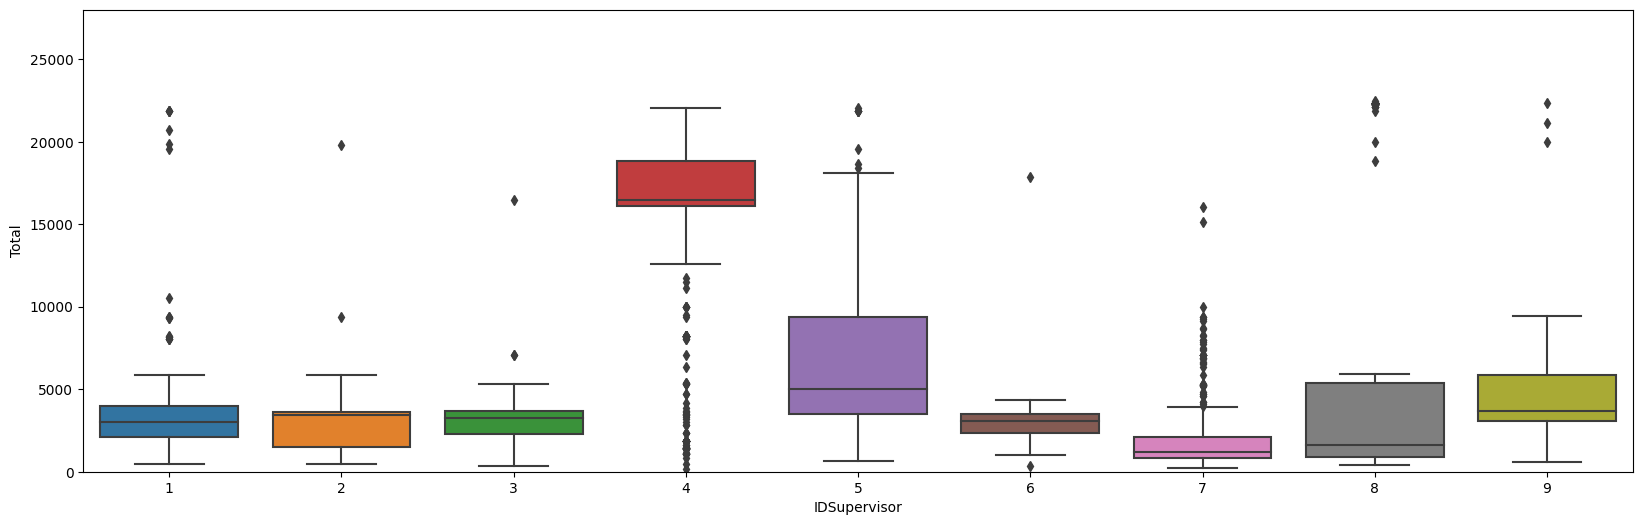

In [ ]:
# Valores atipicos en las cargas de combustible autorizadas por cada supervisor
f, ax = plt.subplots(figsize = (20,6)) #Define el area donde se va a graficar, 15 y 6 es el tamaño que queremos
fig = sns.boxplot(x = var, y = 'Total', data = dataSup) #Armamos los valores del gráfico
fig.axis(ymin = 0, ymax = 28000) #Valores maximos y minimos mostrados en el grafico en el eje y

**Total de combustible autorizado por cada Supervisor**

In [ ]:
# Importe total de combustible cargado en cada estacion de hidrocarburos
sumSup = dfSup[['IDSupervisor', 'Total']].groupby(by = 'IDSupervisor').sum()
sumSup

,Total
IDSupervisor,
1,874780.03
2,750490.59
3,1037817.69
4,7920820.20
5,2373227.96
6,711168.50
7,745271.83
8,1808834.87
9,1322213.54


In [ ]:
sumSup.shape

(9, 1)

<Axes: xlabel='IDSupervisor'>

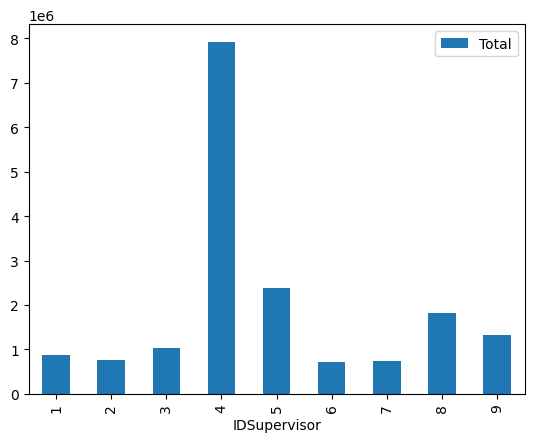

In [ ]:
sumSup.plot.bar()

Al mirar las visualizaciones de los supervisores encontramos valores atipicos propios del esquema de trabajo, ya que como vimos a lo largo de esta presentación la logística de las unidades es variada. tendremos que ajustar algunos detalles para poder mejorar el rendimiento del combustible y prevenir las malas practicas que algunos operadores han adoptado.

# **Conclusión:**

A medida que nos sumergimos en los números detrás de nuestra empresa de transporte, se revelan oportunidades emocionantes para transformar la forma en que operamos. Con un enfoque en la eficiencia y la sostenibilidad, estamos comprometidos en convertir los desafíos en triunfos y los datos en decisiones informadas. Gracias por unirse a nosotros en esta emocionante exploración numérica mientras avanzamos hacia un futuro más brillante y eficiente en el mundo del transporte.

# **Medidas de Tendencia Central y Dispersión en Utilitarios**

**Medidas de Tendencia Central**

In [ ]:
# Promedio del consumo de hidrocarburos en Utilitarios: $927.76
statistics.mean(datauti['Total'])

927.7676265822785

In [ ]:
# Media Geometrica del consumo de hidrocarburos en Utilitarios: $894.24
statistics.geometric_mean(datauti['Total'])

894.2403048080506

In [ ]:
# Mediana del consumo de hidrocarburos en Utilitarios: $867.6
statistics.median(datauti['Total'])

867.6

In [ ]:
# Moda del consumo de hidrocarburos en Utilitarios: $854.0
statistics.mode(datauti['Total'])

854.0

<ipython-input-15-c2d6f442c903>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfUti['Total'])


<Axes: xlabel='Total', ylabel='Density'>

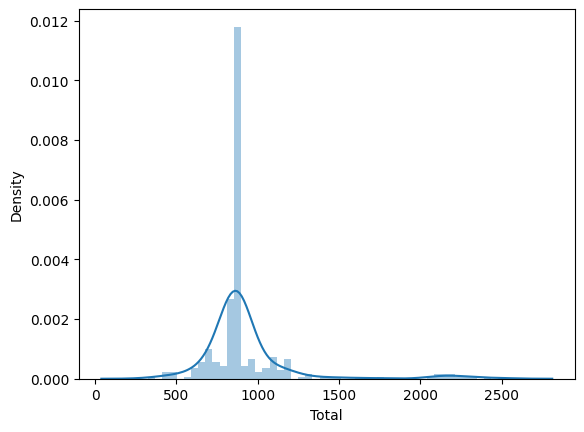

In [ ]:
sns.distplot(dfUti['Total'])

In [ ]:
df = sumuti
fig = px.histogram(df, x="Total", nbins=10)
fig.update_layout(
    title="Comportamiento de las cargas totales de combustible por utilitarios",

    margin=dict(l=140, r=40, b=50, t=80),
    legend=dict(
        font_size=10,
        yanchor='middle',
        xanchor='right',
    ),
    width=800,
    height=600,
    paper_bgcolor='white',
    plot_bgcolor='white',
    hovermode='closest',
)

**Cargas de combustible por mes en el segmento de utilitarios**

<Axes: xlabel='Fecha'>

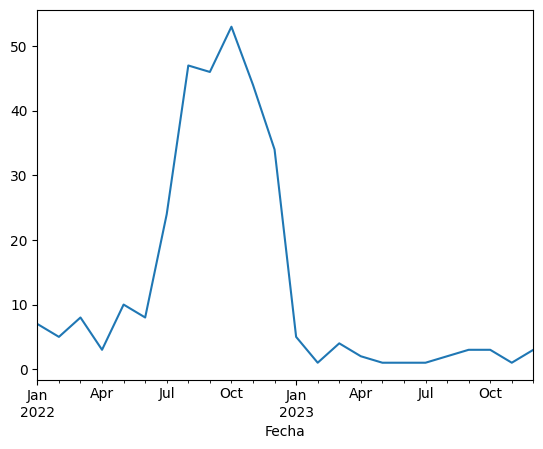

In [ ]:
dfUti['Fecha']=pd.to_datetime(dfUti['Fecha'])
cargasutifecha =dfUti.groupby(dfUti['Fecha'].dt.to_period('M')).size()
cargasutifecha.plot.line()

Podemos observar que las unidades del segmento de utilitarios tuvierón un aumento en las cargas de combustible en Agosto, Septiembre, Octubre y Noviembre del 2022

# **Medidas de Tendencia Central y Dispersión en Vanes y Buses**

**Medidas de Tendencia Central**

In [ ]:
# Promedio del consumo de hidrocarburos en Vanes y Buses: $2128.14
statistics.mean(dfVanB['Total'])

2128.145088888889

In [ ]:
# Media Geometrica del consumo de hidrocarburos en Vanes y Buses: $1617.36
statistics.geometric_mean(dfVanB['Total'])

1617.3678049706946

In [ ]:
# Mediana del consumo de hidrocarburos en Vanes y Buses: $1288.79
statistics.median(dfVanB['Total'])

1288.79

In [ ]:
# Moda del consumo de hidrocarburos en Vanes y Buses: $1192.95
statistics.mode(dfVanB['Total'])

1192.95

<ipython-input-52-562063c9561c>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='Total', ylabel='Density'>

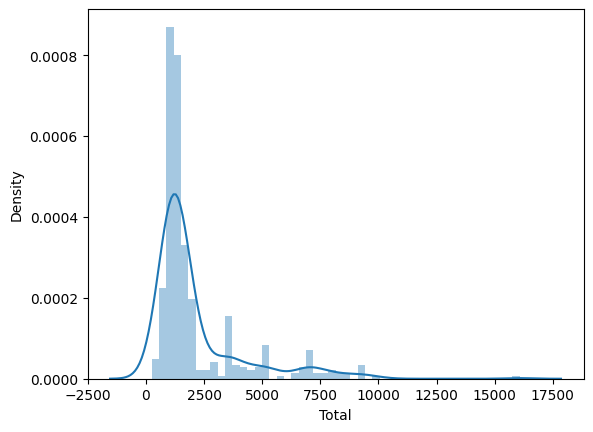

In [ ]:
sns.distplot(dfVanB['Total'])

In [ ]:
df = sumVB
fig = px.histogram(df, x="Total", nbins=10)
fig.update_layout(
    title="Comportamiento de las cargas totales de combustible por Vanes y Buses",

    margin=dict(l=140, r=40, b=50, t=80),
    legend=dict(
        font_size=10,
        yanchor='middle',
        xanchor='right',
    ),
    width=800,
    height=600,
    paper_bgcolor='white',
    plot_bgcolor='white',
    hovermode='closest',
)

**Cargas de combustible por mes en el segmento de Vanes y Buses**

<ipython-input-57-b55668c0d87f>:1: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



<Axes: xlabel='Fecha'>

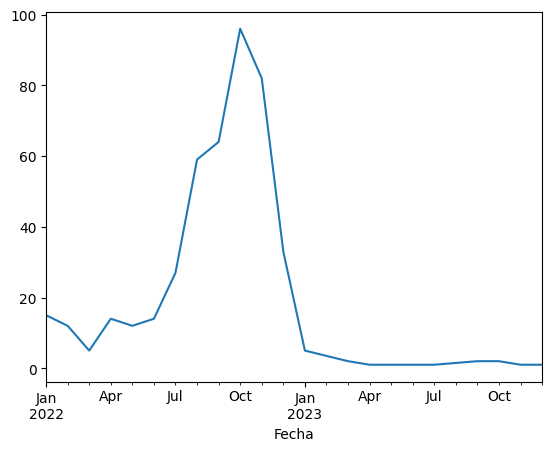

In [ ]:
dfVanB['Fecha'] = pd.to_datetime(dfVanB['Fecha'])
cargasvanbfecha = dfVanB.groupby(dfVanB['Fecha'].dt.to_period('M')).size()
cargasvanbfecha.plot.line()

Podemos observar que las unidades del segmento de Vanes y Buses tuvierón un aumento en las cargas de combustible en Agosto, Septiembre, Octubre y Noviembre del 2022

# **Medidas de Tendencia Central y Dispersión en el Transporte de Personal**

**Medidas de Tendencia Central**

In [ ]:
# Promedio de consumo de hidrocarburos en el Tranporte de Personal: $3321.32
statistics.mean(dataPer['Total'])

3321.3248661417324

In [ ]:
# Media Geometrica del consumo de hidrocarburos en el Tranporte de Personal: $3222.39
statistics.geometric_mean(dataPer['Total'])

3222.3913243675956

In [ ]:
# Mediana del consumo de hidrocarburos en el Transporte de Personal: $3493.5
statistics.median(dataPer['Total'])

3493.5

In [ ]:
# Moda del consumo de hidrocarburos en el Transporte de Personal: $3526
statistics.mode(dataPer['Total'])

3526.5

<ipython-input-73-a55fa939744f>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='Total', ylabel='Density'>

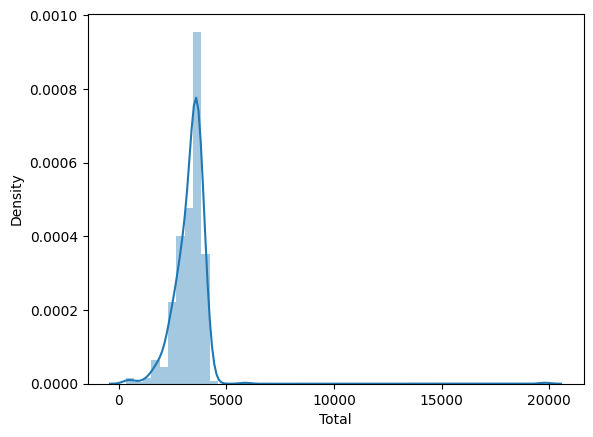

In [ ]:
sns.distplot(dfPer['Total'])

In [ ]:
df = sumPer
fig = px.histogram(df, x="Total", nbins=10)
fig.update_layout(
    title="Comportamiento de las cargas totales de combustible en el Transporte de Personal",

    margin=dict(l=140, r=40, b=50, t=80),
    legend=dict(
        font_size=10,
        yanchor='middle',
        xanchor='right',
    ),
    width=800,
    height=600,
    paper_bgcolor='white',
    plot_bgcolor='white',
    hovermode='closest',
)

Cargas de combustible por mes en el segmento del Transporte de Personal

<Axes: xlabel='Fecha'>

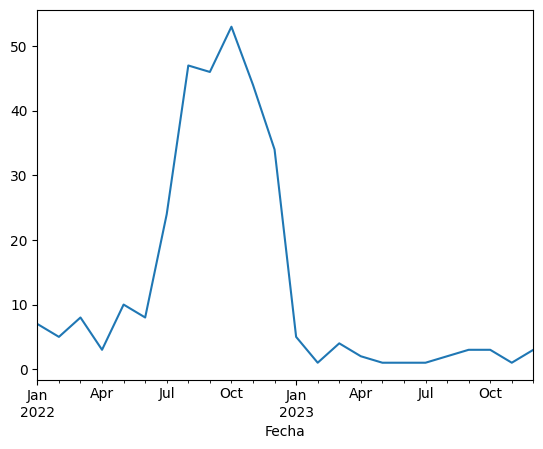

In [ ]:
dfPer['Fecha'] = pd.to_datetime(dfPer['Total'])
cargasperfecha = dfPer.groupby(dfPer['Fecha'].dt.to_period('M')).size()
cargasutifecha.plot.line()

Podemos observar que las unidades del segmento del Transporte de Personal tuvierón un aumento en las cargas de combustible en Agosto, Septiembre, Octubre y Noviembre del 2022

# **Medidas de Tendencia Central y Dispersión en el segmento de Rabones**

**Medidas de Tendencia Central**

In [ ]:
# Promedio del consumo de hidrocarburos en Rabones: $2769.06
statistics.mean(dataRab['Total'])

2769.066808510638

In [ ]:
# Media Geométrica del consumo de hidrocarburos en los Rabones: $2665.53
statistics.geometric_mean(dataRab['Total'])

2665.5344076111264

In [ ]:
# Mediana del consumo de hidrocarburos en los Rabones: $3048.5
statistics.median(dataRab['Total'])

3048.5

In [ ]:
# Moda del consumo de hidrocarburos en los Rabones: $3056.3
statistics.mode(dataRab['Total'])

3056.3

<ipython-input-94-b4ac11afdb89>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='Total', ylabel='Density'>

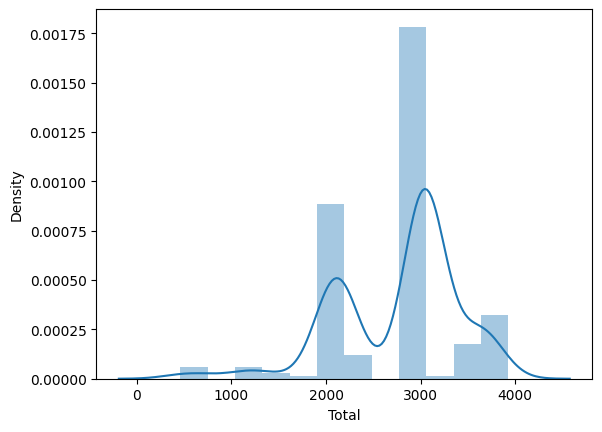

In [ ]:
sns.distplot(dataRab['Total'])

In [ ]:
df = sumRab
fig = px.histogram(df, x="Total", nbins=10)
fig.update_layout(
    title="Comportamiento de las cargas totales de combustible en los Rabones",

    margin=dict(l=140, r=40, b=50, t=80),
    legend=dict(
        font_size=10,
        yanchor='middle',
        xanchor='right',
    ),
    width=800,
    height=600,
    paper_bgcolor='white',
    plot_bgcolor='white',
    hovermode='closest',
)

**Cargas de Combustible por mes en el segmento de Rabones**

<Axes: xlabel='Fecha'>

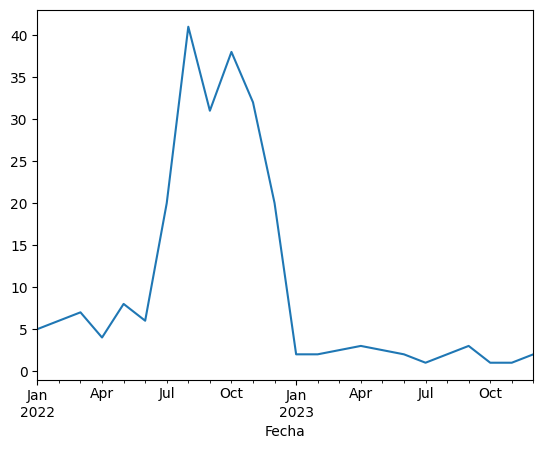

In [ ]:
dfRab['Fecha'] = pd.to_datetime(dfRab['Fecha'])
cargasrabfecha = dfRab.groupby(dfRab['Fecha'].dt.to_period('M')).size()
cargasrabfecha.plot.line()

Podemos revisar que apartir de Junio del 2022 empezo una escalada en el consumo de combustible llegando a un pico maximo en Julio, regresando a niveles promedio en Enero del 2023

# **Medidas de Tendencia Central y Dispersión en el segmento de los Tractocamiones**

Medidas de Tendencia Central

In [ ]:
# Promedio del consumo de hidrocarburos de los Tractocamiones: $10812.38
statistics.mean(dataTra['Total'])

10812.383835504887

In [ ]:
# Media Geometrica del consumo de hidrocarburos de los Tractocamiones: $8299.34
statistics.geometric_mean(dataTra['Total'])

8299.346581400285

In [ ]:
# Mediana del consumo de hidrocarburos de los Tractocamiones: $8228.5
statistics.median(dataTra['Total'])

8228.5

In [ ]:
# Moda del consumo de hidrocarburos del los Tractocamiones: $16457.0
statistics.mode(dataTra['Total'])

16457.0

<ipython-input-20-f2ccbbbd2570>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfTra['Total'])


<Axes: xlabel='Total', ylabel='Density'>

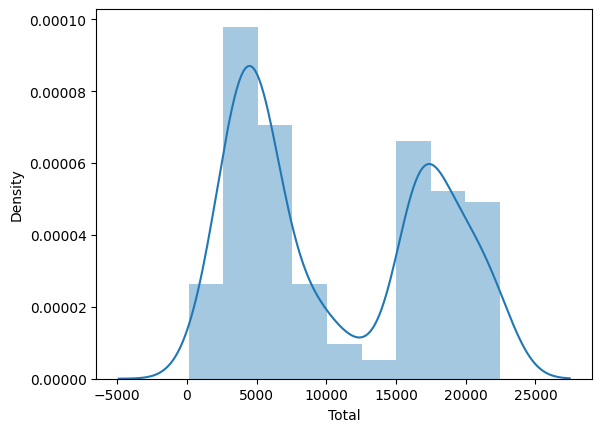

In [ ]:
sns.distplot(dfTra['Total'])

In [ ]:
df = sumTra
fig = px.histogram(df, x="Total", nbins=10)
fig.update_layout(
    title="Comportamiento de las cargas totales de combustible en los Tractocamiones",

    margin=dict(l=140, r=40, b=50, t=80),
    legend=dict(
        font_size=10,
        yanchor='middle',
        xanchor='right',
    ),
    width=800,
    height=600,
    paper_bgcolor='white',
    plot_bgcolor='white',
    hovermode='closest',
)

<ipython-input-25-8d350f042802>:1: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



<Axes: xlabel='Fecha'>

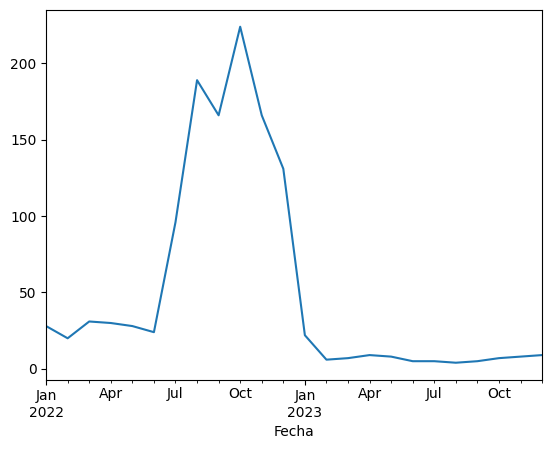

In [ ]:
dfTra['Fecha'] = pd.to_datetime(dfTra['Fecha'])
cargastrafecha = dfTra.groupby(dfTra['Fecha'].dt.to_period('M')).size()
cargastrafecha.plot.line()

Podemos observar que las unidades del segmento de Tractocamiones tuvierón un aumento en las cargas de combustible en Agosto, Septiembre, Octubre y Noviembre del 2022

# **Correlación entre Variables**

In [ ]:
df2.head()

,IDGas,Estación de carga,IDSupervisor,Fecha,IdUtilitarios,IdVanyBus,IdPersonal,IDRabon,IdTracto,IdOp,Tipo de Combustible,Litros,Precio por litro,Total
0,1,ALEJO PUEBLA,5,25/07/2022,,,,,7.0,60,Diesel,95,22.99,2184.05
1,2,ALEJO PUEBLA,5,25/07/2022,,,,,32.0,BAJA,Diesel,760,22.99,17472.40
2,3,ALEJO PUEBLA,2,25/07/2022,,14.0,,,,43,Diesel,65,22.99,1494.35
3,4,ALEJO PUEBLA,2,25/07/2022,,,2.0,,,36,Diesel,120,22.99,2758.80
4,5,ALEJO PUEBLA,5,25/07/2022,,,,,35.0,BAJA,Diesel,850,22.99,19541.50


In [ ]:
corrmat = df2.corr()
corrmat

<ipython-input-49-0baa0518cd31>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,IDGas,IDSupervisor,Litros,Precio por litro,Total
IDGas,1.000000,0.322276,0.050082,0.199569,0.056322
IDSupervisor,0.322276,1.000000,-0.087359,-0.059089,-0.085875
Litros,0.050082,-0.087359,1.000000,0.302084,0.999926
Precio por litro,0.199569,-0.059089,0.302084,1.000000,0.308202
Total,0.056322,-0.085875,0.999926,0.308202,1.000000


<Axes: >

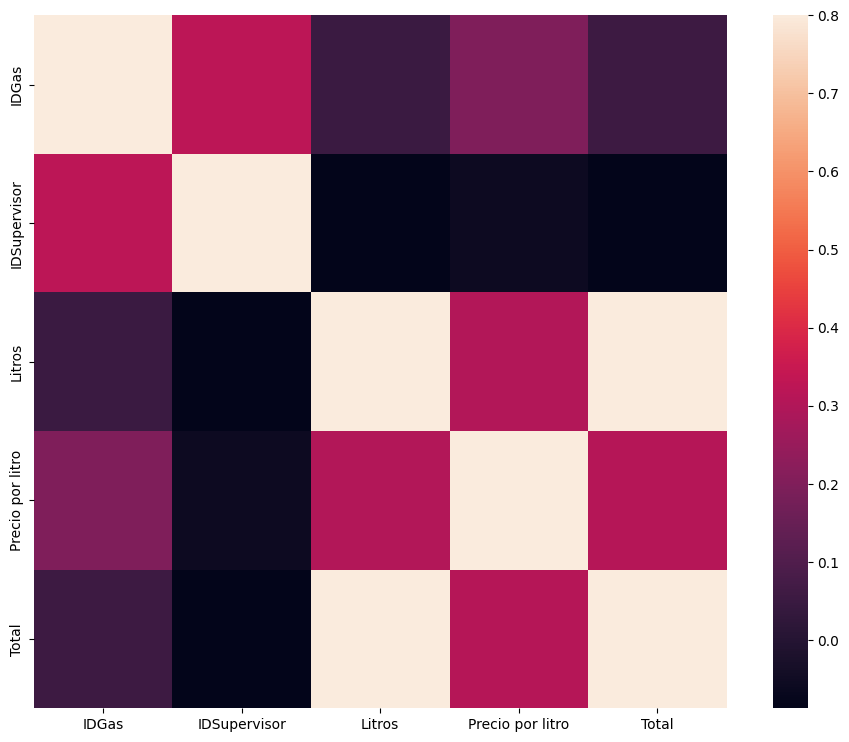

In [ ]:
# Crear Heatmap
f, ax = plt.subplots(figsize = (12,9))
sns.heatmap(corrmat, vmax = .8, square = True)

In [ ]:
var = 'Litros'

In [ ]:
data = pd.concat([df['Total'], df[var]], axis = 1)

In [ ]:
dflitros = df[['Litros', 'Total']]
dflitros.head()

,Litros,Total
0,95,2184.05
1,760,17472.40
2,65,1494.35
3,120,2758.80
4,850,19541.50


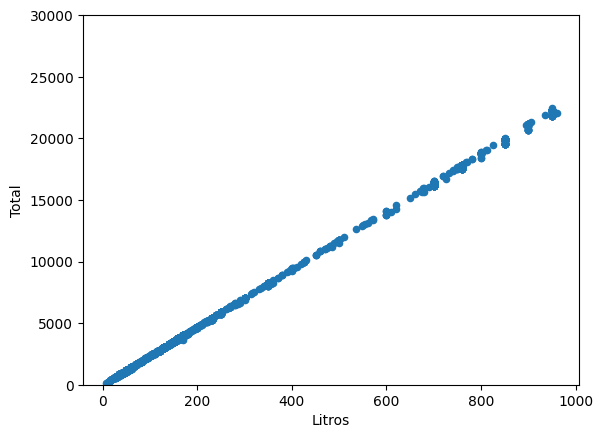

In [ ]:
data.plot.scatter(x = var, y = 'Total', ylim = (0,30000));

Vemos una correlación clara entre los Litros y el Total, por lo tanto no contamos con valores Atípicos.

# **Separación de columnas de sagmentos para despues concatenar en una sola columna**

dfUti - dfVanB - dfPer - dfRab - dfTra

In [ ]:
df2 = df.fillna(0)
df2.head(5)

,IDGas,Estación de carga,IDSupervisor,Fecha,IdUtilitarios,IdVanyBus,IdPersonal,IDRabon,IdTracto,IdOp,Tipo de Combustible,Litros,Precio por litro,Total
0,1,ALEJO PUEBLA,5,25/07/2022,0.0,0.0,0.0,0.0,7.0,60,Diesel,95,22.99,2184.05
1,2,ALEJO PUEBLA,5,25/07/2022,0.0,0.0,0.0,0.0,32.0,BAJA,Diesel,760,22.99,17472.40
2,3,ALEJO PUEBLA,2,25/07/2022,0.0,14.0,0.0,0.0,0.0,43,Diesel,65,22.99,1494.35
3,4,ALEJO PUEBLA,2,25/07/2022,0.0,0.0,2.0,0.0,0.0,36,Diesel,120,22.99,2758.80
4,5,ALEJO PUEBLA,5,25/07/2022,0.0,0.0,0.0,0.0,35.0,BAJA,Diesel,850,22.99,19541.50


**Utilitarios**

In [ ]:
# Agregar Columna Target
dfUti['Target'] = 'Uti'
dfUti.head()

,Fecha,IdUtilitarios,Tipo de Combustible,Litros,Total,Target
5,25/07/2022,1.0,Gasolina,50,1174.5,Uti
59,26/07/2022,7.0,Gasolina,40,851.6,Uti
75,27/07/2022,11.0,Gasolina,40,851.6,Uti
77,27/07/2022,15.0,Gasolina,50,1064.5,Uti
90,28/07/2022,16.0,Gasolina,40,851.6,Uti


In [ ]:
# Eliminar columna del ID del segmento
dfUtix = dfUti.drop(['IdUtilitarios'], axis= 1)
dfUtix.head()

,Fecha,Tipo de Combustible,Litros,Total,Target
5,25/07/2022,Gasolina,50,1174.5,Uti
59,26/07/2022,Gasolina,40,851.6,Uti
75,27/07/2022,Gasolina,40,851.6,Uti
77,27/07/2022,Gasolina,50,1064.5,Uti
90,28/07/2022,Gasolina,40,851.6,Uti


In [ ]:
dfUtix.shape

(316, 5)

Vanes y Buses

In [ ]:
dfVanB['Target'] = 'Van_Bus'
dfVanB.head()

,Fecha,IdVanyBus,Tipo de Combustible,Litros,Total,Target
2,25/07/2022,14.0,Diesel,65,1494.35,Van_Bus
6,25/07/2022,16.0,Gasolina,55,1166.00,Van_Bus
36,26/07/2022,12.0,Gasolina,50,1064.50,Van_Bus
43,26/07/2022,13.0,Diesel,65,1494.35,Van_Bus
47,26/07/2022,3.0,Diesel,225,5172.75,Van_Bus


In [ ]:
dfVanBx = dfVanB.drop(['IdVanyBus'], axis= 1)
dfVanBx.head()

,Fecha,Tipo de Combustible,Litros,Total,Target
2,25/07/2022,Diesel,65,1494.35,Van_Bus
6,25/07/2022,Gasolina,55,1166.00,Van_Bus
36,26/07/2022,Gasolina,50,1064.50,Van_Bus
43,26/07/2022,Diesel,65,1494.35,Van_Bus
47,26/07/2022,Diesel,225,5172.75,Van_Bus


In [ ]:
dfVanBx.count()

Fecha                  450
Tipo de Combustible    450
Litros                 450
Total                  450
Target                 450
dtype: int64

Personal

In [ ]:
dfPer['Target'] = 'Per'
dfPer.head()

,Fecha,IdPersonal,Tipo de Combustible,Litros,Total,Target
3,25/07/2022,2.0,Diesel,120,2758.80,Per
10,25/07/2022,10.0,Diesel,130,2988.70,Per
15,25/07/2022,6.0,Diesel,135,3103.65,Per
17,25/07/2022,11.0,Diesel,150,3448.50,Per
18,25/07/2022,21.0,Diesel,160,3678.40,Per


In [ ]:
dfPerx = dfPer.drop(['IdPersonal'], axis= 1)
dfPerx.head()

,Fecha,Tipo de Combustible,Litros,Total,Target
3,25/07/2022,Diesel,120,2758.80,Per
10,25/07/2022,Diesel,130,2988.70,Per
15,25/07/2022,Diesel,135,3103.65,Per
17,25/07/2022,Diesel,150,3448.50,Per
18,25/07/2022,Diesel,160,3678.40,Per


In [ ]:
dfPerx.count()

Fecha                  635
Tipo de Combustible    635
Litros                 635
Total                  635
Target                 635
dtype: int64

Rabones

In [ ]:
dfRab['Target'] = 'Rab'
dfRab.head()

,Fecha,IDRabon,Tipo de Combustible,Litros,Total,Target
7,25/07/2022,6.0,Diesel,100,2299.0,Rab
24,25/07/2022,3.0,Diesel,90,2069.1,Rab
37,26/07/2022,5.0,Diesel,130,2988.7,Rab
39,26/07/2022,4.0,Diesel,130,2988.7,Rab
45,26/07/2022,1.0,Diesel,90,2069.1,Rab


In [ ]:
dfRabx = dfRab.drop(['IDRabon'], axis = 1)
dfRabx.head()

,Fecha,Tipo de Combustible,Litros,Total,Target
7,25/07/2022,Diesel,100,2299.0,Rab
24,25/07/2022,Diesel,90,2069.1,Rab
37,26/07/2022,Diesel,130,2988.7,Rab
39,26/07/2022,Diesel,130,2988.7,Rab
45,26/07/2022,Diesel,90,2069.1,Rab


In [ ]:
dfRabx.count()

Fecha                  235
Tipo de Combustible    235
Litros                 235
Total                  235
Target                 235
dtype: int64

Tractocamiones

In [ ]:
dfTra['Target'] = 'Trac'
dfTra.head()

,Fecha,IdTracto,Tipo de Combustible,Litros,Total,Target
0,25/07/2022,7.0,Diesel,95,2184.05,Trac
1,25/07/2022,32.0,Diesel,760,17472.40,Trac
4,25/07/2022,35.0,Diesel,850,19541.50,Trac
8,25/07/2022,36.0,Diesel,60,1379.40,Trac
9,25/07/2022,20.0,Diesel,900,20691.00,Trac


In [ ]:
dfTrax = dfTra.drop(['IdTracto'], axis = 1)
dfTrax.head()

,Fecha,Tipo de Combustible,Litros,Total,Target
0,25/07/2022,Diesel,95,2184.05,Trac
1,25/07/2022,Diesel,760,17472.40,Trac
4,25/07/2022,Diesel,850,19541.50,Trac
8,25/07/2022,Diesel,60,1379.40,Trac
9,25/07/2022,Diesel,900,20691.00,Trac


In [ ]:
dfTrax.count()

Fecha                  1228
Tipo de Combustible    1228
Litros                 1228
Total                  1228
Target                 1228
dtype: int64

Unión de todos DF

In [ ]:
dfr = pd.concat([dfUtix, dfVanBx, dfPerx, dfRabx, dfTrax])
dfr.head()

,Fecha,Tipo de Combustible,Litros,Total,Target
5,25/07/2022,Gasolina,50,1174.5,Uti
59,26/07/2022,Gasolina,40,851.6,Uti
75,27/07/2022,Gasolina,40,851.6,Uti
77,27/07/2022,Gasolina,50,1064.5,Uti
90,28/07/2022,Gasolina,40,851.6,Uti


In [ ]:
dfr.shape

(2864, 5)

In [ ]:
df0 = dfr[:316] #Utilitarios
df1 = dfr[316:766] #Vanes y Buses
df2 = dfr[766:1401] #Personal
df3 = dfr[1401:1636] #Rabones
df4 = dfr[1636:] #Tractocamiones

# **SVC y KNN**



In [ ]:
# Todos las columnas menos los valores a predecir
# Sacar columnas que nosean int o float
X = dfr.drop(['Fecha', 'Tipo de Combustible', 'Target'], axis = 1)
X.head()
#X = dfr.drop(['Target'], axis = 1)
#X.head()

,Litros,Total
5,50,1174.5
59,40,851.6
75,40,851.6
77,50,1064.5
90,40,851.6


In [ ]:
y = dfr['Target']
y.head()

5     Uti
59    Uti
75    Uti
77    Uti
90    Uti
Name: Target, dtype: object

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
svm = SVC()
svm_scores = cross_val_score(svm, X, y, cv = 7, scoring = 'accuracy')
svm_scores.mean()

0.7007871667958734

In [ ]:
knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X, y, cv = 7, scoring = 'accuracy')
knn_scores.mean()

0.7077626232077899

**Train test split**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
len(X_train)

2004

In [ ]:
len(x_test)

860

In [ ]:
knn2 = KNeighborsClassifier(n_neighbors=9, metric='euclidean')

In [ ]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [ ]:
knn.score(x_test, y_test)

0.7930232558139535

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[134,  11,  37,   3,   4],
       [  7,  59,   1,   2,   1],
       [ 29,   5, 327,   2,   5],
       [  0,   2,   1,  77,  12],
       [ 14,   3,  13,  26,  85]])

In [ ]:
#y_pred

In [ ]:
acc = knn.score(x_test, y_test)
acc

0.7930232558139535

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         Per       0.73      0.71      0.72       189
         Rab       0.74      0.84      0.79        70
        Trac       0.86      0.89      0.88       368
         Uti       0.70      0.84      0.76        92
     Van_Bus       0.79      0.60      0.69       141

    accuracy                           0.79       860
   macro avg       0.76      0.78      0.77       860
weighted avg       0.79      0.79      0.79       860



Text(58.222222222222214, 0.5, 'Truth')

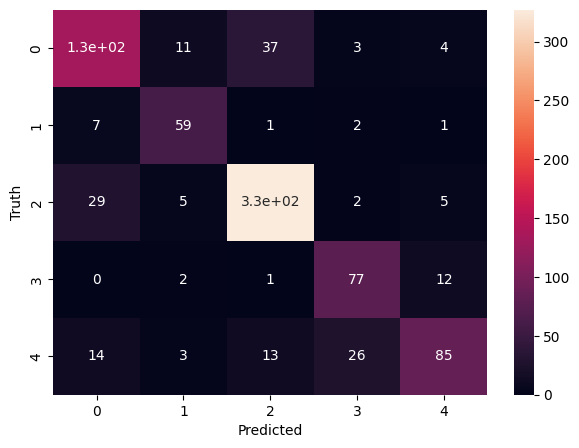

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Minumun error:  0.2069767441860465 at n_neighbors 9


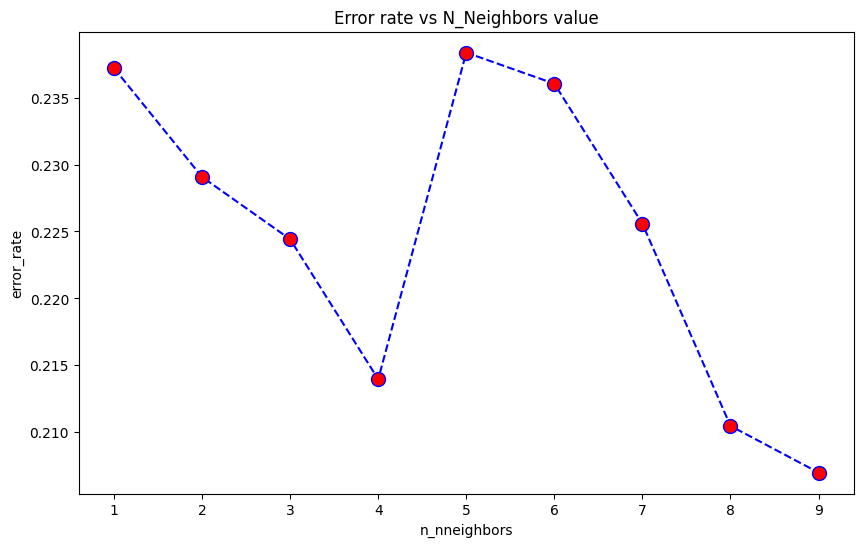

In [ ]:
# mejor valor para n_neighbors
error_rate = []
for i in range(1,10):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train, y_train)
  pred_i = knn.predict(x_test)
  error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,10), error_rate, color='blue', linestyle='dashed',
         marker='o',markerfacecolor='red',markersize=10)
plt.title('Error rate vs N_Neighbors value')
plt.xlabel('n_nneighbors')
plt.ylabel('error_rate')
print('Minumun error: ', min(error_rate), 'at n_neighbors', error_rate.index(min(error_rate))+1)

# **API Conversor de divisas**

Utilizamos un conversor de divisas de USD a MXN, por que al momento de adquirir nuevas unidades, cajas secas, o determinadas refacciones están cotizado su precio en dolares.

In [ ]:
# Importando librerías
import requests
import json

In [ ]:
url = 'http://data.fixer.io/api/latest?access_key=7370ff2962d49abefc56c32f5bc74aa8'

In [ ]:
from requests.api import request
response = requests.get(url)

In [ ]:
def currency_conversion():
    from_currency = input('USD O MXN:')
    to_currency   = input('USD O MXN:')
    amount    = int(input('Cantidad        :'))
    response = requests.get(url)
    rate = response.json()['rates'][from_currency]
    amount_in_MXN = amount/rate
    amount = amount_in_MXN*(response.json()['rates'][to_currency])
    amount = round(amount,2)
    print(amount)
    again = input('Quiere una nueva conversión? (CONTESTAR SI O NO) :')
    if again == 'SI':
        currency_conversion()


currency_conversion()

USD O MXN:USD
USD O MXN:MXN
Cantidad        :510
8974.22
Quiere una nueva conversión? (CONTESTAR SI O NO) :NO
